1. Define a key metric that monitors the success of an effort to improve the guest host matching process. Why?
2. Suggest areas of improvement to increase # bookings in Rio de Janeiro.
    - Segments doing well, what can be improved?
    - 2-3 recommendations that addresses these opportunities
    - Provide rationale and rank in terms of impact
3. Help execs understand the broader framing of the problem and provide other approaches that could help the company    get more clarity on the issue.
    


There are 3 ways to send a host an inquiry:
    - contact_me
    - book_it
    - instant_book

In [947]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option("display.max_columns",400)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.backends.backend_pdf
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

### Top-level goal: Improve booking rate in RdJ
NOTE: Data could include provide price of listing to see analyze if price could be factor towards booking intent.
Data could include whether the user interacted with the filtering option when finding a listing


In [3]:
contacts = pd.read_csv('contacts.csv')
listings = pd.read_csv('listings.csv')
users = pd.read_csv('users.csv')

Contacts​ -​ contains a row for every time that a user makes an inquiry for a stay at a listing in Rio de Janeiro.
- id_guest_anon -​ id of the guest making the inquiry.
- id_host_anon -​ id of the host of the listing to which the inquiry is made.
- id_listing_anon -​ id of the listing to which the inquiry is made.
- ts_interaction_first -​ UTC timestamp of the moment the inquiry is made.
- ts_reply_at_first ​- UTC timestamp of the moment the host replies to the inquiry, if so.
- ts_accepted_at_first -​ UTC timestamp of the moment the host accepts the inquiry, if so.
- ts_booking_at - UTC timestamp of the moment the booking is made, if so.
- ds_checkin_first ​- Date stamp of the check​-in date of the inquiry.
- ds_checkout_first ​- Date stamp of the check-​out date of the inquiry.
- m_guests ​- The number of guests the inquiry is for.
- m_interactions -​ The total number of messages sent by both the guest and host.
- m_first_message_length_in_characters -​ Number of characters in the first message sent by the guest, if a
message was sent
- contact_channel_first -​ The contact channel through which the inquiry was made. One of {contact_me,
book_it, instant_book}. *See bottom of page for more detail*
- guest_user_stage_first ​- Indicates whether the user has made a booking before sending the inquiry (“past
booker”). If the user has not booked before, then the user is a new user.

Users​ -​ contains data for every user
- id_user_anon ​- anonymized id of user
- words_in_user_profile - the number of words in the “about me” section of the user’s Airbnb profile (at
the time of contact)
- country -​ origin country of the user

Listings​ -​ contains data for every listing in the market
- id_listing_anon ​- anonymized id of the listing
- room_type -​ indicates whether the room is an entire home, private room, or shared room
- listing_neighborhood -​ the neighborhood of the listing
- total_reviews -​ the total number of reviews of the listing (at the time the data was pulled).

### User dataset - potential questions
- Does the user's country or origin effect the booking rate of a listing?
- A user that is more engaged with their profile, more likely to make a booking?

potential improvements to dataset:
    - add age of account. The age of an account could influence how likely a user is to book a place because they are more experienced.
    - add number of bookings the account made. A more active account could make them more likely to book a place.
    - number of amenities provided. The aminities can be a major selling point for the listing and draw users to 
    want to make a booking.
    - Provide number of bed+bathrooms. The listing just might not accomodate the users preferences based on the number of guests.
    - age/gender of user. The age or gender could be factor in whether they are more likely to book. Could cater the posting to a particular demographic.

### Data Cleaning - Users

In [4]:
print ('Number of observations: '+str(users.shape[0]))
users.head()

Number of observations: 31525


id_user_anon country  words_in_user_profile
0  1d16a001-31a2-494c-a101-1f7b308adc62      FR                      0
1  42607e0a-86c0-472e-b633-9e192114e93c      AR                      0
2  25f85eb5-a700-44e1-b142-4c076222198d      BR                      0
3  55abeba0-18ef-4c58-80f4-3c278b706aca      BR                      1
4  5d62d35a-7d6d-45dd-ae9b-a5d2f82a7d7b      BR                     98

In [15]:
#Check null values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31525 entries, 0 to 31524
Data columns (total 3 columns):
id_user_anon             31525 non-null object
country                  31524 non-null object
words_in_user_profile    31525 non-null int64
dtypes: int64(1), object(2)
memory usage: 738.9+ KB


In [16]:
#duplicate users
print ('Number of duplicate users = ' + str(sum(users['id_user_anon'].value_counts(dropna=False)>1)))

Number of duplicate users = 68


In [17]:
#Get list of duplicate userids
user_counts = users['id_user_anon'].value_counts(dropna=False)
dup_users = user_counts[user_counts>1].index
user_dup_df = users[users['id_user_anon'].isin(dup_users)].sort_values('id_user_anon')

In [18]:
#Count number of duplicate rows
users[users['id_user_anon'].isin(dup_users)].sort_values('id_user_anon').shape

(136, 3)

In [19]:
#Get count of duplicate rows
user_dup_df.groupby(user_dup_df.columns.tolist(),as_index=False).size().value_counts(dropna=False)

2    68
dtype: int64

Drop duplicate rows


In [20]:
users.drop_duplicates(inplace=True)

In [21]:
print ('1 user did not choose a country. This person can be dropped since it adds a bit of a bias, though small.')
users[users.isna().any(axis=1)]

1 user did not choose a country. This person can be dropped since it adds a bit of a bias, though small.


id_user_anon country  words_in_user_profile
18866  e0e03982-682e-4a58-a3f7-9f393e4875d6     NaN                      0

In [22]:
users = users.drop(18866).reset_index(drop=True)

In [23]:
#Check if there are no duplicate listing_ids in the listings table
len(users['id_user_anon']) == len(np.unique(users['id_user_anon']))

True

In [36]:
for col in users.columns:
    unique = sorted(users[col].unique())
    print (str(col) + '   ' + str(len(unique)) + '   ' + str(unique[:5]))


id_user_anon   31456   ['000053cd-ab28-4cb3-b17a-e31c2ad8e553', '00006c1d-a931-4808-abbf-71dbef32f8e7', '0004610d-e88c-4c1f-93ef-6d127686714d', '0004d595-e42e-4fe7-b238-1528f4436fed', '0005d72f-42ca-45cc-8700-8e1124ff56a8']
country   121   ['AE', 'AO', 'AR', 'AT', 'AU']
words_in_user_profile   363   [0, 1, 2, 3, 4]


### Data Visualization - Users

In [24]:
countries = users.groupby('country').size().sort_values(ascending=False)
countries = pd.DataFrame(countries,columns=['count']).reset_index()

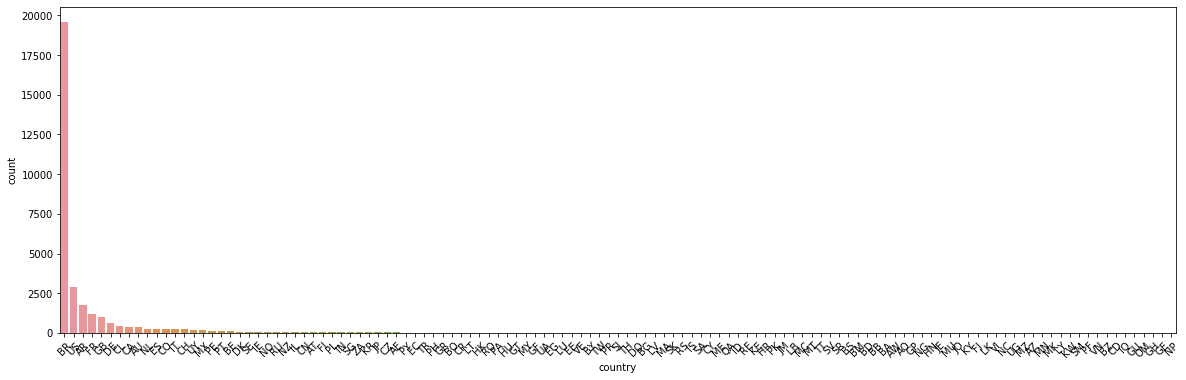

In [25]:
#Visualization of countries
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
ax = sns.barplot(x='country',y='count', data=countries)


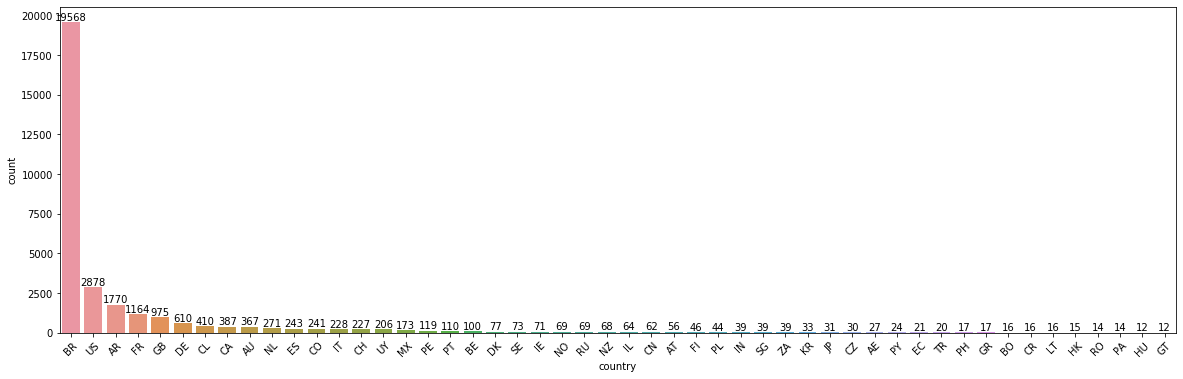

In [26]:
#Look at the top 50 countries
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
ax = sns.barplot(x='country',y='count', data=countries[:50])
# Make some labels.
rects = ax.patches
labels = list(countries[:50]['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [28]:
print (str(countries[countries['country']=='BR']['count']/countries['count'].sum()))

0    0.622075
Name: count, dtype: float64


62.2% of users are from Brazil

In [29]:
words_used = users.groupby('words_in_user_profile').size().sort_values(ascending=False)
words_used = pd.DataFrame(words_used,columns=['count']).reset_index()

In [30]:
words_used = words_used.sort_values('words_in_user_profile')

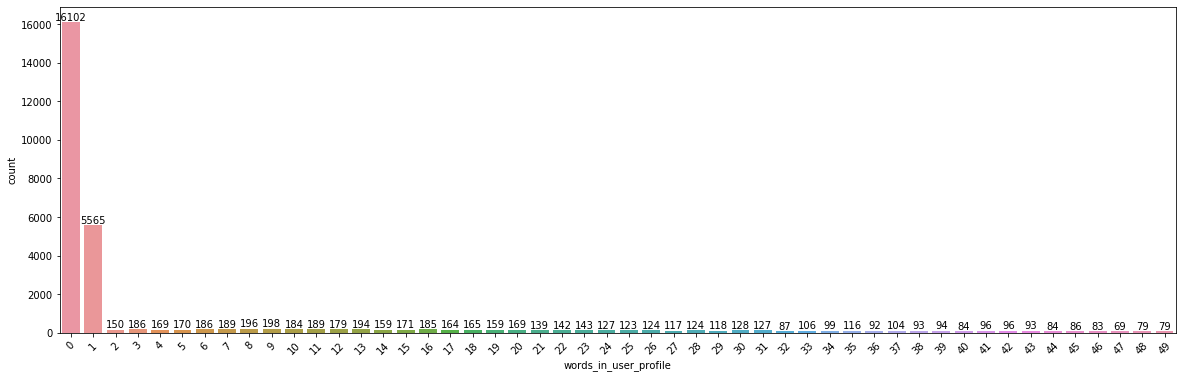

In [31]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
ax = sns.barplot(x='words_in_user_profile',y='count', data=words_used[:50])
# Make some labels.
rects = ax.patches
labels = list(words_used[:50]['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [32]:
words_used[words_used['words_in_user_profile']< 2]['count'].sum()*1.0/words_used['count'].sum()

0.6888034079348931

68.9% of users use less than 2 words in their profile

___________

### Listing dataset - potential questions
- Does the room type matter when it comes to getting a listing booked?
- Does the neighborhood influence the booking?
- Do the number of total reviews effect the booking rate?

potential improvements to dataset:
    - add rating of the listing. Ratings serve as an indicator for how satisfied a user was with the booking.
    - add price of the listing. Price can be a major influencer towards a user's intent to make a booking.
    - number of amenities provided. The aminities can be a major selling point for the listing and draw users to 
    want to make a booking.
    - Provide number of bed+bathrooms. The listing just might not accomodate the users preferences based on the number of guests.

### Data Cleaning - Listings

In [33]:
print ('Number of observations: '+str(listings.shape[0]))
listings.head()

Number of observations: 13038


id_listing_anon        room_type listing_neighborhood  \
0  71582793-e5f8-46d7-afdf-7a31d2341c79     Private room            -unknown-   
1  a1a3f728-e21f-4432-96aa-361d28e2b319  Entire home/apt           Copacabana   
2  353a68be-ecf9-4b7b-9533-c882dc2f0760  Entire home/apt      Barra da Tijuca   
3  b9ae1908-0486-40ac-bbcf-bd63ffebfe63  Entire home/apt                 Lapa   
4  fa0290ef-7881-4482-8981-8ebb1ce5dbfd  Entire home/apt            -unknown-   

   total_reviews  
0            0.0  
1            0.0  
2            3.0  
3            4.0  
4            0.0

In [35]:
for col in listings.columns:
    unique = sorted(listings[col].unique())
    print (str(col) + '   ' + str(len(unique)) + '   ' + str(unique[:5]))


id_listing_anon   13038   ['0000527e-5d88-43e5-b40c-1931c9d12c38', '00030baf-b903-4d9a-9c33-ea4212cf48e1', '00046935-e2ae-4e0a-a549-30e975d40ddd', '00068b5f-4fb9-4b25-8814-830df5e68b23', '000a1497-8e45-4abc-bafb-c99dd142b856']
room_type   3   ['Entire home/apt', 'Private room', 'Shared room']
listing_neighborhood   68   ['-unknown-', 'Abolição', 'Andaraí', 'Barra da Tijuca', 'Barros Filho']
total_reviews   172   [-34.0, -33.0, -32.0, -27.0, -26.0]


##### Why are there negative number of reviews??

In [885]:
#Check null values
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13038 entries, 0 to 13037
Data columns (total 4 columns):
id_listing_anon         13038 non-null object
room_type               13038 non-null object
listing_neighborhood    13038 non-null object
total_reviews           13038 non-null float64
dtypes: float64(1), object(3)
memory usage: 407.5+ KB


No null values found

In [39]:
#Check if there are no duplicate listing_ids in the listings table
len(listings['id_listing_anon']) == len(np.unique(listings['id_listing_anon']))

True

##### Analyze total reviews negative value

In [37]:
listings[listings['total_reviews'] < 0].shape[0]*1.0/listings.shape[0]

0.0031446540880503146

The negative number of review counts only account for 0.3% of all listings. We will drop this in the meantime but should follow up with the product team to see if there is something in the backend that is not counting the number of reviews properly.

In [38]:
listings = listings[listings['total_reviews'] > -1]

### Data Visualization - Listings

In [40]:
def plot_bar(data,col,top):
    grouped = pd.DataFrame(data[col].value_counts(dropna=False)).reset_index()
    columns=[col,'count']
    grouped.columns = columns
    #Convert city names to UTF-8 format for labeling purposes
    if grouped[col].dtype == np.object:
        grouped[col] = grouped[col].str.decode(encoding = 'UTF-8') 
    #plot
    plt.figure(figsize=(20,6))
    plt.xticks(rotation=45)
    ax = sns.barplot(x=col,y='count', data=grouped[:top])
    # Make some labels.
    rects = ax.patches
    labels = list(grouped[:top]['count'])

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
    plt.show()


ValueError: min() arg is an empty sequence

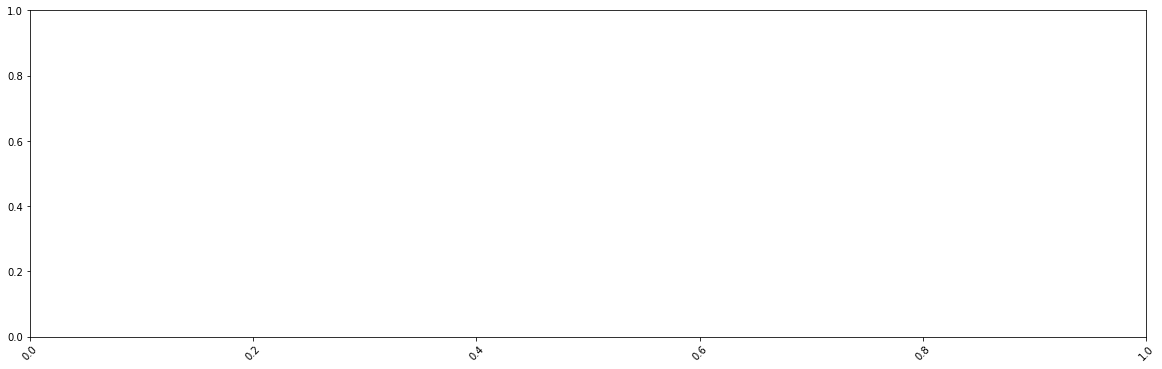

In [51]:
plot_bar(listings,'listing_neighborhood',20)

In [380]:
listings[listings['listing_neighborhood']=='-unknown-'].count()[0]*1.0/listings.shape[0]

0.4768792798338078

47.7% of listings do NOT provide the city location. This may be a significant factor that influences whether a user will book that listing. Maybe make a recommendation to the product team that a host must make a indication of the location of the property.

In [381]:
listings['room_type'].value_counts(dropna=False)

Entire home/apt    9618
Private room       3008
Shared room         371
Name: room_type, dtype: int64

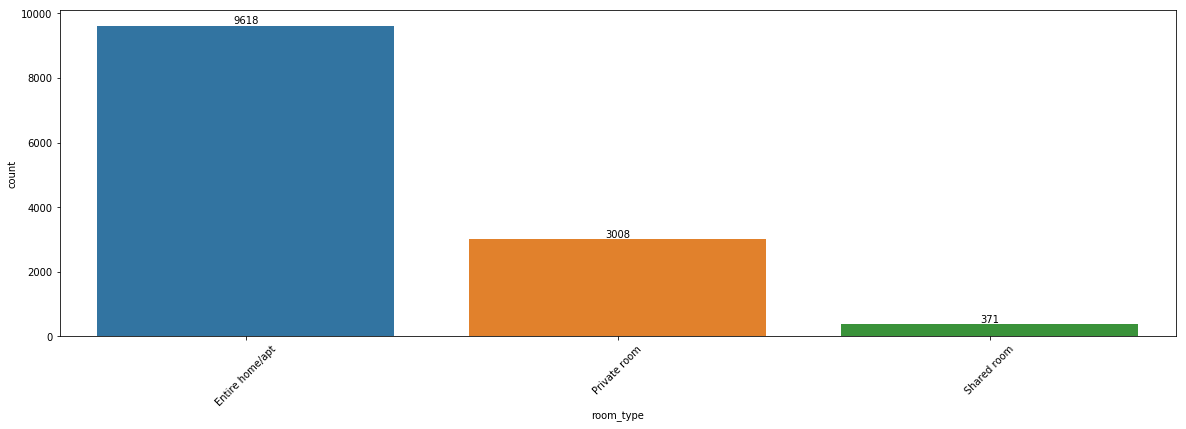

In [382]:
plot_bar(listings,'room_type',10)

### Data Cleaning - Contacts

- ts_interaction_first -​ UTC timestamp of the moment the inquiry is made.
- ts_reply_at_first ​- UTC timestamp of the moment the host replies to the inquiry, if so.
- ts_accepted_at_first -​ UTC timestamp of the moment the host accepts the inquiry, if so.
- ts_booking_at - UTC timestamp of the moment the booking is made, if so.
- ds_checkin_first ​- Date stamp of the check​-in date of the inquiry.
- ds_checkout_first ​- Date stamp of the check-​out date of the inquiry.
- m_guests ​- The number of guests the inquiry is for.
- m_interactions -​ The total number of messages sent by both the guest and host.
- m_first_message_length_in_characters -​ Number of characters in the first message sent by the guest, if a message was sent
- contact_channel_first -​ The contact channel through which the inquiry was made. One of {contact_me, book_it, instant_book}. See bottom of page for more detail
- guest_user_stage_first ​- Indicates whether the user has made a booking before sending the inquiry (“past booker”). If the user has not booked before, then the user is a new user.

In [888]:
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27887 entries, 0 to 27886
Data columns (total 14 columns):
id_guest_anon                           27887 non-null object
id_host_anon                            27887 non-null object
id_listing_anon                         27887 non-null object
ts_interaction_first                    27887 non-null object
ts_reply_at_first                       25855 non-null object
ts_accepted_at_first                    16415 non-null object
ts_booking_at                           11587 non-null object
ds_checkin_first                        27887 non-null object
ds_checkout_first                       27887 non-null object
m_guests                                27886 non-null float64
m_interactions                          27887 non-null int64
m_first_message_length_in_characters    27887 non-null float64
contact_channel_first                   27887 non-null object
guest_user_stage_first                  27887 non-null object
dtypes: float64(2), in

In [889]:
contacts.head()

id_guest_anon                          id_host_anon  \
0  da8656a1-51af-4f38-b1c4-94be1f585157  5426897d-960d-4013-9e38-606ae746793c   
1  8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37  f30417c5-6df4-45ac-bfc2-6ad1cce398ab   
2  ebcd83ba-bda1-47eb-9680-2dd04ccf3988  13cbf50a-3272-45d4-9866-a06b6ea1b99a   
3  b0af8848-fe2a-4ef1-991e-26ab3066feb3  01614601-d5a4-4776-ab9b-c10d3b865bf0   
4  5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2  f2fed6f3-4c5c-453d-9e64-37c62b8bd06d   

                        id_listing_anon   ts_interaction_first  \
0  a408a8b2-0d44-4513-a611-3736d0409bb2    2016-04-21 02:55:53   
1  e387c705-0aeb-464c-9375-ece63be6f006    2016-02-16 22:14:01   
2  d1eb1960-938f-4305-a353-51e224414dd4    2016-01-27 23:33:38   
3  855f6779-346c-45fc-a64b-ea133250ca7a    2016-05-05 14:42:52   
4  f2928a59-c5e7-42b2-9c37-240a40f38dc0  2016-06-23 03:09:25.0   

       ts_reply_at_first   ts_accepted_at_first          ts_booking_at  \
0  2016-04-21 03:15:00.0  2016-04-21 03:15:00.0  2016-04-21 03:15:00.0   
1  2016-02-16 23:37:36.0                    NaN                    NaN   
2  2016-01-28 02:12:47.0                    NaN                    NaN   
3  2016-05-05 15:17:40.0  2016-05-05 15:17:40.0                    NaN   
4  2016-06-23 03:09:26.0  2016-06-23 03:09:33.0  2016-06-23 03:09:33.0   

  ds_checkin_first ds_checkout_first  m_guests  m_interactions  \
0       2016-08-02        2016-08-06       4.0              30   
1       2016-08-11        2016-08-22       5.0               2   
2       2016-03-14        2016-03-23       1.0               3   
3       2016-05-27        2016-05-29       2.0               3   
4       2016-08-19        2016-08-21       3.0              25   

   m_first_message_length_in_characters contact_channel_first  \
0                                  31.0               book_it   
1                                 312.0            contact_me   
2                                 164.0            contact_me   
3                                 203.0            contact_me   
4                                   0.0          instant_book   

  guest_user_stage_first  
0            past_booker  
1            past_booker  
2                    new  
3                    new  
4            past_booker

In [17]:
for col in contacts.columns:
    unique = sorted(contacts[col].unique())
    print str(col) + '   ' + str(len(unique)) + '   ' + str(unique[:5])


id_guest_anon   22566   ['00006c1d-a931-4808-abbf-71dbef32f8e7', '0004610d-e88c-4c1f-93ef-6d127686714d', '0004d595-e42e-4fe7-b238-1528f4436fed', '0005d72f-42ca-45cc-8700-8e1124ff56a8', '000811c6-4a5e-482c-90b4-9b7ffce40586']
id_host_anon   8959   ['000053cd-ab28-4cb3-b17a-e31c2ad8e553', '0010edbc-b857-4a2f-8f13-c53d6a7c3f2f', '00169ce3-1cc8-4982-824f-e6fe992c8655', '0019225e-7045-4913-9b93-d96f7fb0a7b9', '0019ff6e-774f-470f-af39-d12107744c01']
id_listing_anon   12819   ['0000527e-5d88-43e5-b40c-1931c9d12c38', '00030baf-b903-4d9a-9c33-ea4212cf48e1', '00046935-e2ae-4e0a-a549-30e975d40ddd', '00068b5f-4fb9-4b25-8814-830df5e68b23', '000a1497-8e45-4abc-bafb-c99dd142b856']
ts_interaction_first   27871   ['2016-01-01 00:46:47', '2016-01-01 01:15:04', '2016-01-01 03:11:41', '2016-01-01 05:14:48', '2016-01-01 06:28:35']
ts_reply_at_first   25835   [nan, '2016-01-01 01:07:50.0', '2016-01-01 03:58:13.0', '2016-01-01 12:24:15.0', '2016-01-01 12:33:31.0']
ts_accepted_at_first   16410   [nan, '2016-0

convert float object nans to empty string and remove microseconds then convert to datetime

In [42]:
def clean_timestamp(df, col):
    df[col] = np.where(df[col].notnull(),df[col],"")
    df[col] = [x.split('.',1)[0] for x in df[col]]
    df[col] = df[col].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != '' else '')

In [43]:
clean_timestamp(contacts, 'ts_interaction_first')
clean_timestamp(contacts, 'ts_reply_at_first')
clean_timestamp(contacts, 'ts_accepted_at_first')
clean_timestamp(contacts, 'ts_booking_at')

In [44]:
contacts['ds_checkin_first'] = contacts['ds_checkin_first'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
contacts['ds_checkout_first'] = contacts['ds_checkout_first'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [46]:
#CONTACTS
print (contacts.shape)
contacts.head(20)

(27887, 14)


id_guest_anon  \
0   da8656a1-51af-4f38-b1c4-94be1f585157   
1   8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37   
2   ebcd83ba-bda1-47eb-9680-2dd04ccf3988   
3   b0af8848-fe2a-4ef1-991e-26ab3066feb3   
4   5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2   
5   25940fca-7aa9-480d-9cf0-56cc1136d30c   
6   ee6633e1-96de-47f6-96e7-d962fc6db7dd   
7   b3357bab-cf20-4646-b723-23ae84fc8fb3   
8   e52ccc38-1ca1-48b4-a10a-08663601dbbb   
9   177cddfa-fe47-4668-81bf-884490a6707b   
10  8cb51614-2851-4d3d-93a6-620556ace3de   
11  b88f0944-8278-49c1-928c-eac65ca3a8d2   
12  a2c8d522-41df-4b49-9aaf-6c4b3d95afed   
13  c463ff6c-c2bf-474a-86c3-7fc979e08020   
14  0e07d4e8-2c3c-4848-b9dc-f7a859309e80   
15  255d7130-faea-4965-be56-96414335df6d   
16  bcd2c6bb-c5bf-484a-9cfc-ba13b8a0a9be   
17  e3939be4-b42e-40ec-a01e-e8d3c3a5be4f   
18  433f68eb-cf81-4d44-a15f-69c6f813a928   
19  b577b943-e463-4c5d-b762-c28b8cf2165f   

                            id_host_anon  \
0   5426897d-960d-4013-9e38-606ae746793c   
1   f30417c5-6df4-45ac-bfc2-6ad1cce398ab   
2   13cbf50a-3272-45d4-9866-a06b6ea1b99a   
3   01614601-d5a4-4776-ab9b-c10d3b865bf0   
4   f2fed6f3-4c5c-453d-9e64-37c62b8bd06d   
5   90334ef3-f489-45a0-89e0-d18d370e4a1c   
6   10dc3fc4-694f-44b2-aaac-9dbace0ebabd   
7   7e0696cb-6321-4d60-a8e9-793ee14724fd   
8   1c990fca-5b09-4eca-bdcf-d9e923112f04   
9   2bd81140-3d71-4fd9-add3-5998f9263c57   
10  7a7c50a7-2a19-44a7-ab5c-b2b658ebcf8b   
11  bf6e95ec-966d-46af-9bfe-f2dd91523571   
12  3d046d4c-b456-4fdc-b1db-9ee1a7a441a9   
13  a66f8d54-84ac-4220-9296-a5037370a5b6   
14  e540b776-3f0f-498b-ad8a-a0ecc54df286   
15  efa7ea8b-e78c-48d1-abfd-1dfc06c48e61   
16  d5bcd535-92a1-4337-9148-6b53ce87c311   
17  90b34959-9aaa-40d9-9874-439f12d3acd8   
18  af7f1101-3b5d-4e45-822a-0a2fd1dcf4bb   
19  e086d187-8e1e-4810-9f74-d3204043601c   

                         id_listing_anon ts_interaction_first  \
0   a408a8b2-0d44-4513-a611-3736d0409bb2  2016-04-21 02:55:53   
1   e387c705-0aeb-464c-9375-ece63be6f006  2016-02-16 22:14:01   
2   d1eb1960-938f-4305-a353-51e224414dd4  2016-01-27 23:33:38   
3   855f6779-346c-45fc-a64b-ea133250ca7a  2016-05-05 14:42:52   
4   f2928a59-c5e7-42b2-9c37-240a40f38dc0  2016-06-23 03:09:25   
5   5dd24057-774c-45b3-b305-ebf664246952  2016-04-19 07:08:21   
6   259d4a6c-dcda-4ff2-85cb-2882f6801b3a  2016-05-30 15:16:21   
7   75de5296-f7df-45d2-9c18-af332a082784  2016-03-10 12:13:46   
8   f6822854-6d3c-4cfd-a983-49603a401771  2016-04-24 06:46:42   
9   cff02e60-1205-42fa-afd4-0c23029ce32e  2016-04-26 02:11:47   
10  472ead4a-63a3-422e-8c98-1745f773e2c0  2016-01-10 18:09:45   
11  1f51882a-4abd-4bd4-be6d-a75ae8be4986  2016-06-03 22:40:22   
12  96169363-f4e6-4a15-8a2f-90d93c6ae469  2016-02-20 03:51:52   
13  64930c5b-232a-4c93-af86-fe8e8dfc276c  2016-02-28 18:03:02   
14  efbd8ae0-75e5-4d05-be3a-1c150ce3a9fd  2016-04-13 07:37:53   
15  4c1011e5-da80-4c45-a5f9-a5ae9ff4e58f  2016-01-06 18:58:31   
16  7e367f14-45a8-4a7c-a328-3e151cf71fed  2016-01-07 06:12:42   
17  ed510d46-74ec-4870-9024-48f29ff12bad  2016-01-20 15:14:21   
18  a3722b1e-fd37-4fa0-a7b7-8e10b1eda61e  2016-01-24 20:54:34   
19  eb4799d5-aa04-4402-9bec-9625f6700e4e  2016-05-19 12:27:11   

     ts_reply_at_first ts_accepted_at_first       ts_booking_at  \
0  2016-04-21 03:15:00  2016-04-21 03:15:00 2016-04-21 03:15:00   
1  2016-02-16 23:37:36                  NaT                 NaT   
2  2016-01-28 02:12:47                  NaT                 NaT   
3  2016-05-05 15:17:40  2016-05-05 15:17:40                 NaT   
4  2016-06-23 03:09:26  2016-06-23 03:09:33 2016-06-23 03:09:33   
5  2016-04-19 11:32:23                  NaT                 NaT   
6  2016-05-30 15:18:55  2016-06-01 23:38:20                 NaT   
7  2016-03-10 12:13:47  2016-03-10 12:13:47 2016-03-10 12:13:47   
8  2016-04-24 06:46:42  2016-04-24 06:46:42 2016-04-24 06:46:42   
9  2016-04-26 02:16:39                  NaT                 NaT   
10 2016-01-11 15:19:22                  NaT                 NaT   
11 2016

Add calculated metrics to help analyze the data
- Length of time a host takes to reply to an inquiry
- Length of time for host to accept an inquiry from interaction_first
- Length of time for host to accept booking from inquiry
- identifier that the contact lead to a booking
- Length of stay
- length of time between checkin date and booking date
- check-in occur during a major holiday

In [47]:
#Length of time a host takes to reply to an inquiry (minutes)
contacts['reply_inq_mins'] = (contacts['ts_reply_at_first']-contacts['ts_interaction_first']).apply(lambda x: x.total_seconds())/60

#Length of time for host to accept an inquiry from interaction_first(minutes)
contacts['accept_inq_mins'] = (contacts['ts_accepted_at_first']-contacts['ts_interaction_first']).apply(lambda x: x.total_seconds())/60

#Length of time for host to accept booking from inquiry(minutes)
contacts['book_inq_mins'] = (contacts['ts_booking_at']-contacts['ts_interaction_first']).apply(lambda x: x.total_seconds())/60

#identifier that the contact lead to a booking (0=failed, 1=succeeded)
contacts['booked'] = np.where(contacts['ts_booking_at'].notnull(),1,0)

#Length of stay
contacts['nights_stayed'] = (contacts['ds_checkout_first']-contacts['ds_checkin_first']).apply(lambda x: x.days-1)

#length of time between checkin date and booking date
contacts['book_to_checkin'] = (contacts['ds_checkin_first']-contacts['ts_booking_at']).apply(lambda x: x.days)

#get day of week for check in date (Mon=0, Tues=1 ... Sun=6)
contacts['checkin_dow'] = contacts['ds_checkin_first'].apply(lambda x: x.weekday())

#get day of week + month + year of inquiry
contacts['inquiry_week'] = contacts['ts_interaction_first'].apply(lambda x: x.weekday())
contacts['inquiry_month'] = contacts['ts_interaction_first'].apply(lambda x: x.month)
contacts['inquiry_year'] = contacts['ts_interaction_first'].apply(lambda x: x.year)

#get day of week + month + year of bookings
contacts['booking_week'] = contacts['ts_booking_at'].apply(lambda x: x.weekday())
contacts['booking_month'] = contacts['ts_booking_at'].apply(lambda x: x.month)
contacts['booking_year'] = contacts['ts_booking_at'].apply(lambda x: x.year)

In [48]:
contacts.head()

id_guest_anon                          id_host_anon  \
0  da8656a1-51af-4f38-b1c4-94be1f585157  5426897d-960d-4013-9e38-606ae746793c   
1  8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37  f30417c5-6df4-45ac-bfc2-6ad1cce398ab   
2  ebcd83ba-bda1-47eb-9680-2dd04ccf3988  13cbf50a-3272-45d4-9866-a06b6ea1b99a   
3  b0af8848-fe2a-4ef1-991e-26ab3066feb3  01614601-d5a4-4776-ab9b-c10d3b865bf0   
4  5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2  f2fed6f3-4c5c-453d-9e64-37c62b8bd06d   

                        id_listing_anon ts_interaction_first  \
0  a408a8b2-0d44-4513-a611-3736d0409bb2  2016-04-21 02:55:53   
1  e387c705-0aeb-464c-9375-ece63be6f006  2016-02-16 22:14:01   
2  d1eb1960-938f-4305-a353-51e224414dd4  2016-01-27 23:33:38   
3  855f6779-346c-45fc-a64b-ea133250ca7a  2016-05-05 14:42:52   
4  f2928a59-c5e7-42b2-9c37-240a40f38dc0  2016-06-23 03:09:25   

    ts_reply_at_first ts_accepted_at_first       ts_booking_at  \
0 2016-04-21 03:15:00  2016-04-21 03:15:00 2016-04-21 03:15:00   
1 2016-02-16 23:37:36                  NaT                 NaT   
2 2016-01-28 02:12:47                  NaT                 NaT   
3 2016-05-05 15:17:40  2016-05-05 15:17:40                 NaT   
4 2016-06-23 03:09:26  2016-06-23 03:09:33 2016-06-23 03:09:33   

  ds_checkin_first ds_checkout_first  m_guests  m_interactions  \
0       2016-08-02        2016-08-06       4.0              30   
1       2016-08-11        2016-08-22       5.0               2   
2       2016-03-14        2016-03-23       1.0               3   
3       2016-05-27        2016-05-29       2.0               3   
4       2016-08-19        2016-08-21       3.0              25   

   m_first_message_length_in_characters contact_channel_first  \
0                                  31.0               book_it   
1                                 312.0            contact_me   
2                                 164.0            contact_me   
3                                 203.0            contact_me   
4                                   0.0          instant_book   

  guest_user_stage_first  reply_inq_mins  accept_inq_mins  book_inq_mins  \
0            past_booker       19.116667        19.116667      19.116667   
1            past_booker       83.583333              NaN            NaN   
2                    new      159.150000              NaN            NaN   
3                    new       34.800000        34.800000            NaN   
4            past_booker        0.016667         0.133333       0.133333   

   booked  nights_stayed  book_to_checkin  checkin_dow  inquiry_week  \
0       1              3            102.0            1             3   
1       0             10              NaN            3             1   
2       0              8              NaN            0             2   
3       0              1              NaN            4             3   
4       1              1             56.0            4             3   

   inquiry_month  inquiry_year  booking_week  booking_month  booking_year  
0              4          2016           3.0            4.0        2016.0  
1              2          2016           NaN            NaN           NaN  
2              1          2016           NaN            NaN           NaN  
3              5          2016           NaN            NaN           NaN  
4              6          2016           3.0            6.0        2016.0

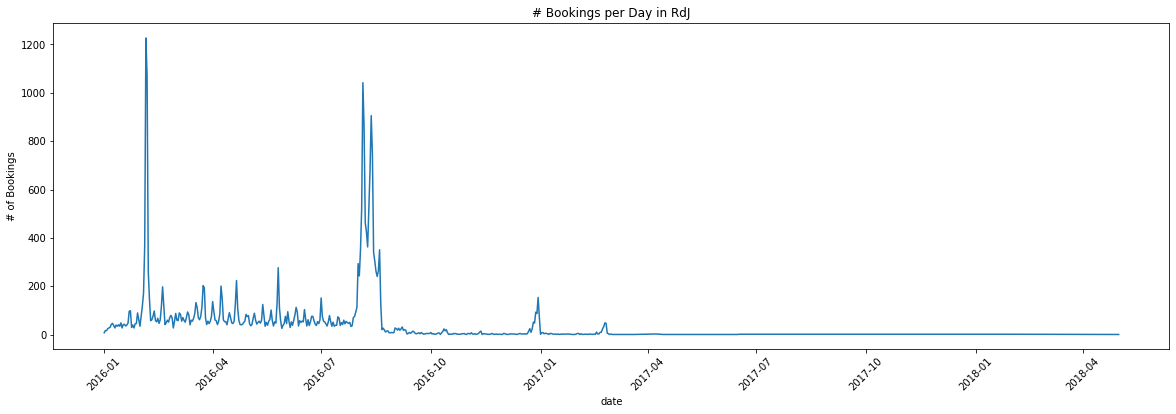

In [50]:

plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
plt.plot(contacts['ds_checkin_first'].value_counts().sort_index())
plt.xlabel('date')
plt.ylabel('# of Bookings')
plt.title('# Bookings per Day in RdJ')
plt.show()


What is causing the sharp decrease in bookings during the Q4 of 2016??

In [52]:
pd.DataFrame(contacts['ds_checkin_first'].value_counts().sort_index())

ds_checkin_first
2016-01-01                 8
2016-01-02                17
2016-01-03                17
2016-01-04                25
2016-01-05                28
2016-01-06                31
2016-01-07                43
2016-01-08                47
2016-01-09                38
2016-01-10                28
2016-01-11                40
2016-01-12                35
2016-01-13                41
2016-01-14                35
2016-01-15                49
2016-01-16                28
2016-01-17                42
2016-01-18                43
2016-01-19                36
2016-01-20                40
2016-01-21                48
2016-01-22                97
2016-01-23                99
2016-01-24                30
2016-01-25                40
2016-01-26                28
2016-01-27                45
2016-01-28                46
2016-01-29                90
2016-01-30                63
...                      ...
2017-02-15                 3
2017-02-16                 1
2017-02-17                11
2017-02-18                 3
2017-02-19                 3
2017-02-20                10
2017-02-21                10
2017-02-22                24
2017-02-23                33
2017-02-24                49
2017-02-25                47
2017-02-26                 6
2017-02-27                 4
2017-02-28                 1
2017-03-01                 3
2017-03-02                 1
2017-03-03                 1
2017-03-04                 1
2017-03-05                 1
2017-03-06                 1
2017-03-07                 1
2017-03-17                 1
2017-03-20                 1
2017-04-08                 3
2017-04-14                 1
2017-05-18                 1
2017-06-15                 1
2017-06-17                 2
2018-01-25                 2
2018-05-01                 1

[422 rows x 1 columns]

In [826]:
unique_date = pd.date_range(start='2016-01-01',end='2018-05-01', freq='D')
unique_date = pd.DataFrame(unique_date,columns=['date'])
checkin_df = pd.DataFrame(contacts['ds_checkin_first'].value_counts().reset_index())
checkin_df.columns = ['date','bookings']
checkin_df = unique_date.merge(checkin_df,how='left')

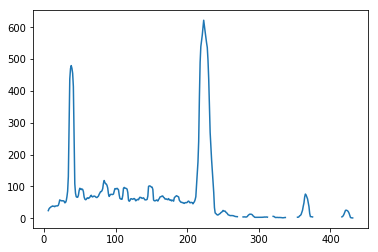

In [833]:
#rolling 7-day window 
rolling_7_bookings = pd.DataFrame(checkin_df['bookings']).rolling(window=7).mean()
plt.plot(rolling_7_bookings)
plt.show()

#### Holidays/Events in Brazil in 2016

- 2016 Olympics: 2016-08-05 to 2016-08-21
- Carnival Rio: 2016-02-06 to 2016-02-10
- Corpus Christi: 2016-05-26
- Tiradentes Day: 2016-04-21
- Good Friday: 2016-03-25
- Labor Day: 2016-05-01
- Independence Day: 2016-09-07

### Merge a datasets 

In [53]:
unique_date = pd.date_range(start='2016-01-01',end='2018-05-01', freq='D')
unique_date = pd.DataFrame(unique_date,columns=['date'])

In [56]:
str(len(set(contacts['id_host_anon'])))

'8959'

In [57]:
#number of unique guest and host ids in Contacts table
print ('# unique host ids: ' + str(len(set(contacts['id_host_anon']))))
print ('# unique guest ids: ' + str(len(set(contacts['id_guest_anon']))))
#number of unique ids in user table
print ('# unique user ids: ' + str(len(set(users['id_user_anon']))))

# unique host ids: 8959
# unique guest ids: 22566
# unique user ids: 31456


In [115]:
df_merged = contacts.merge(
        users,
        right_on='id_user_anon',
        left_on='id_host_anon',
        how='left').merge(
            users,
            right_on='id_user_anon',
            left_on='id_guest_anon',
            how='left')

In [116]:
df_merged.columns

Index(['id_guest_anon', 'id_host_anon', 'id_listing_anon',
       'ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first',
       'ts_booking_at', 'ds_checkin_first', 'ds_checkout_first', 'm_guests',
       'm_interactions', 'm_first_message_length_in_characters',
       'contact_channel_first', 'guest_user_stage_first', 'reply_inq_mins',
       'accept_inq_mins', 'book_inq_mins', 'booked', 'nights_stayed',
       'book_to_checkin', 'checkin_dow', 'inquiry_week', 'inquiry_month',
       'inquiry_year', 'booking_week', 'booking_month', 'booking_year',
       'id_user_anon_x', 'country_x', 'words_in_user_profile_x',
       'id_user_anon_y', 'country_y', 'words_in_user_profile_y'],
      dtype='object')

In [117]:
df_merged.columns = [u'id_guest_anon', u'id_host_anon', u'id_listing_anon',
       u'ts_interaction_first', u'ts_reply_at_first', u'ts_accepted_at_first',
       u'ts_booking_at', u'ds_checkin_first', u'ds_checkout_first',
       u'm_guests', u'm_interactions', u'm_first_message_length_in_characters',
       u'contact_channel_first', u'guest_user_stage_first', u'reply_inq_mins',
       u'accept_inq_mins', u'book_inq_mins', u'booked', u'nights_stayed',
       u'book_to_checkin', u'checkin_dow', u'inquiry_week',u'inquiry_month',
       u'inquiry_year', u'booking_week', u'booking_month', u'booking_year',
       u'id_user_anon_x', u'host_country', u'host_words_in_user_profile', 
       u'id_user_anon_y', u'guest_country', u'guest_words_in_user_profile']
del df_merged['id_user_anon_x']
del df_merged['id_user_anon_y']

In [118]:
del df_merged['id_user_anon_x']
del df_merged['id_user_anon_y']

In [119]:
#Merge listings table
df_merged = df_merged.merge(listings,on='id_listing_anon',how='left')

In [120]:
#Decode to UTF-8 to handle special characters
#df_merged['listing_neighborhood'] = df_merged['listing_neighborhood'].str.decode(encoding = 'UTF-8') 

In [121]:
categorical_features = ['checkin_dow','host_country','guest_country','room_type','listing_neighborhood','contact_channel_first','guest_user_stage_first']
continuous_features = ['m_guests','m_interactions','m_first_message_length_in_characters','reply_inq_mins','accept_inq_mins','book_inq_mins','nights_stayed','book_to_checkin','host_words_in_user_profile','guest_words_in_user_profile','total_reviews']

In [122]:
def get_null(data,col):
    print (col + ': ' + str(len(data[data[col].isnull()])))

In [123]:
df_merged[df_merged['guest_country'].isnull()]

id_guest_anon  \
26968  e0e03982-682e-4a58-a3f7-9f393e4875d6   

                               id_host_anon  \
26968  5519285d-a301-48d3-b318-ca8c8295f8f2   

                            id_listing_anon ts_interaction_first  \
26968  4b508130-4674-471d-8ade-a3064fa0d0a2  2016-06-17 18:52:40   

        ts_reply_at_first ts_accepted_at_first ts_booking_at ds_checkin_first  \
26968 2016-06-20 00:50:57                  NaT           NaT       2016-08-04   

      ds_checkout_first  m_guests  m_interactions  \
26968        2016-08-12       4.0               3   

       m_first_message_length_in_characters contact_channel_first  \
26968                                  76.0               book_it   

      guest_user_stage_first  reply_inq_mins  accept_inq_mins  book_inq_mins  \
26968                    new     3238.283333              NaN            NaN   

       booked  nights_stayed  book_to_checkin  checkin_dow  inquiry_week  \
26968       0              7              NaN            3             4   

       inquiry_month  inquiry_year  booking_week  booking_month  booking_year  \
26968              6          2016           NaN            NaN           NaN   

      host_country  host_words_in_user_profile guest_country  \
26968           BR                           0           NaN   

       guest_words_in_user_profile        room_type listing_neighborhood  \
26968                          NaN  Entire home/apt            -unknown-   

       total_reviews  
26968            0.0

In [124]:
for col in categorical_features:
    get_null(df_merged,col)

checkin_dow: 0
host_country: 0
guest_country: 1
room_type: 92
listing_neighborhood: 92
contact_channel_first: 0
guest_user_stage_first: 0


In [128]:
for col in continuous_features:
    get_null(df_merged,col)

m_guests: 0
m_interactions: 0
m_first_message_length_in_characters: 0
reply_inq_mins: 2032
accept_inq_mins: 11470
book_inq_mins: 16298
nights_stayed: 0
book_to_checkin: 16298
host_words_in_user_profile: 0
guest_words_in_user_profile: 0
total_reviews: 92


In [126]:
#drop 2 users with a null value for number of guests
df_merged.drop([24738,26968],inplace=True)
df_merged.reset_index(drop=True,inplace=True)

### Plot Distribution and Univariable Plots for Features 
continuous features
- m_guests
- m_interactions
- m_first_message_length_in_characters
- reply_inq_mins
- accept_inq_mins
- book_inq_mins
- nights_stayed
- book_to_checkin
- host_words_in_user_profile
- guest_words_in_user_profile
- total_reviews

categorical features

- checkin_dow
- host_country
- guest_country
- room_type
- listing_neighborhood
- contact_channel_first
- guest_user_stage_first

In [129]:
for i in categorical_features:
    print (i)

checkin_dow
host_country
guest_country
room_type
listing_neighborhood
contact_channel_first
guest_user_stage_first


In [130]:
def dist_count_plot(data,col,target):
    
    def run():
        plot(data,col,target)
    
    def plot(data,col,target):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 16))
        sns.countplot(x=col, hue=target,data=data, ax=ax[0])
        ax[0].set_title('Count Plot of {}'.format(col), fontsize=16)
        ax[0].set_yscale('log')
        sns.barplot(x=col,y=target,data=data,ax=ax[1], ci=None)
        ax[1].set_title('Mean Conversion Rate per {}'.format(col), fontsize=16)
        plt.tight_layout()
        plt.show()
            
    run()

In [76]:
def dist_uni_plot(data,col,target,cohort=None):
    
    def run():
        if cohort is not None:
            cohorts = set(data[cohort])
            for c in cohorts:
                data_cohort = data[data[cohort] == c]
                plot(data_cohort,col,target,cohort = c)
        else:
            plot(data,col,target,cohort=None)
    
    def plot(data,col,target,cohort=None):
        data = data[data[col].notnull()]
        grouped = data[[col,target]].groupby(col).mean().reset_index()
        hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
        sns.distplot(data[data[target]==0][col],label='Booked 0',
                    ax=ax[0], hist_kws = hist_kws)
        sns.distplot(data[data[target]==1][col],label='Booked 1',
                    ax=ax[0], hist_kws = hist_kws)
        if cohort is not None:
            ax[0].set_title('Count Plot of {}'.format(col) + '  {}'.format(cohort), fontsize=16)
        else:
            ax[0].set_title('Count Plot of {}'.format(col), fontsize=16)
        ax[0].legend()
        ax[1].plot(grouped[col],grouped[target],'.-')
        if cohort is not None:
            ax[1].set_title('Mean Conversion Rate vs. {}'.format(col) + '  {}'.format(cohort), fontsize=16)
        else:
            ax[1].set_title('Mean Conversion Rate vs. {}'.format(col), fontsize=16)
        ax[1].set_xlabel('{}'.format(col))
        ax[1].set_ylabel('Mean Convertion Rate')
        ax[1].grid(True)
        plt.tight_layout()
        plt.show()
    
    run()
    
    
   

### Categorical Features Plots

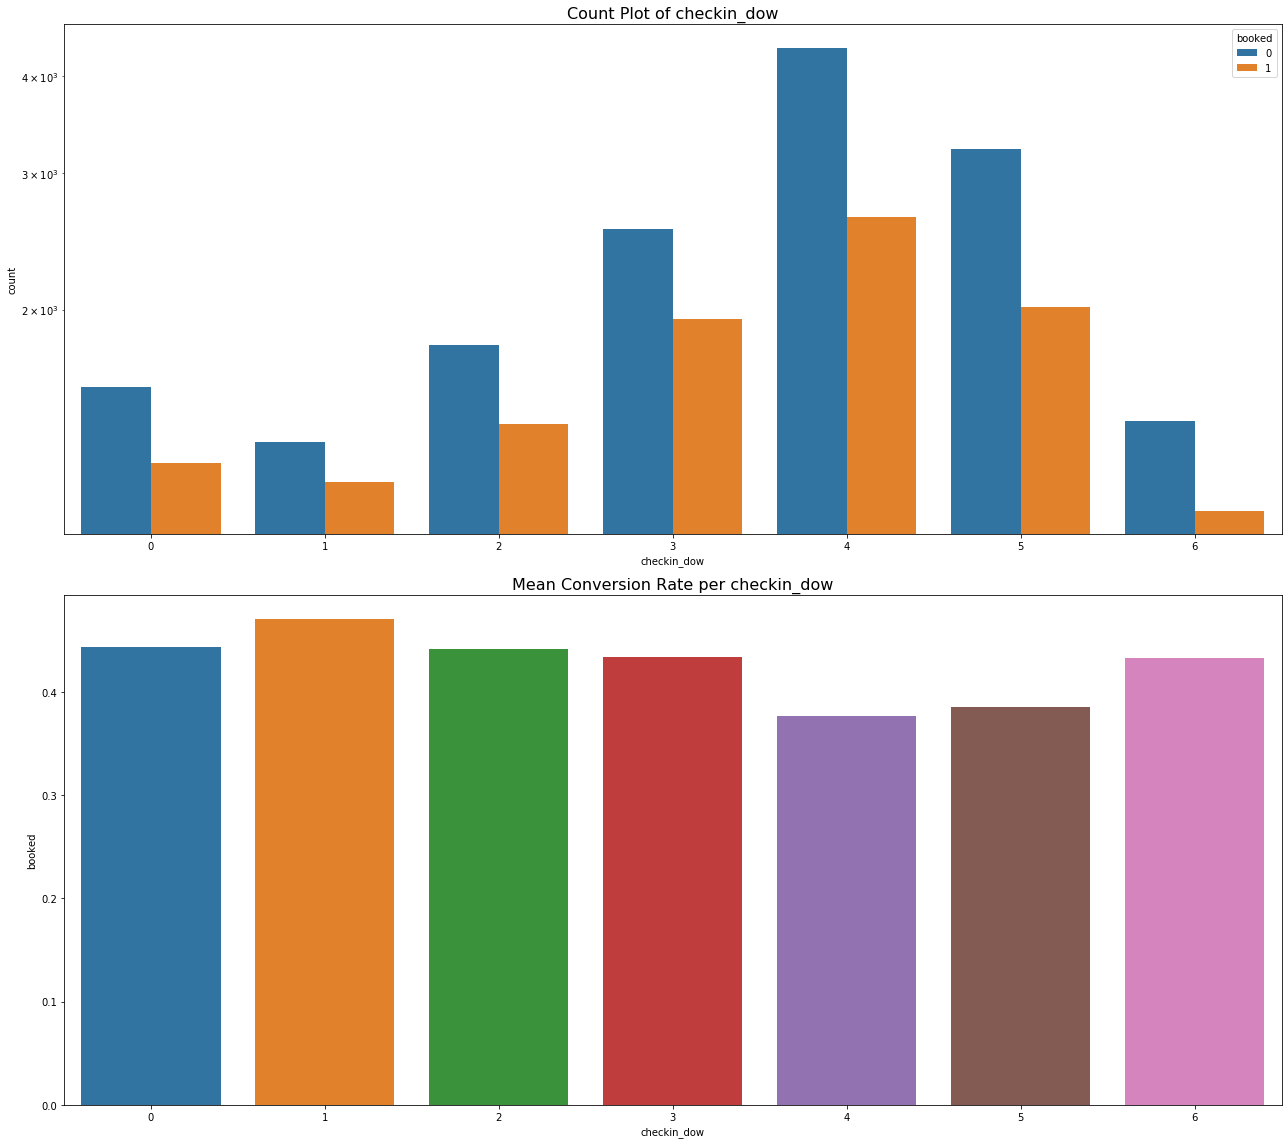

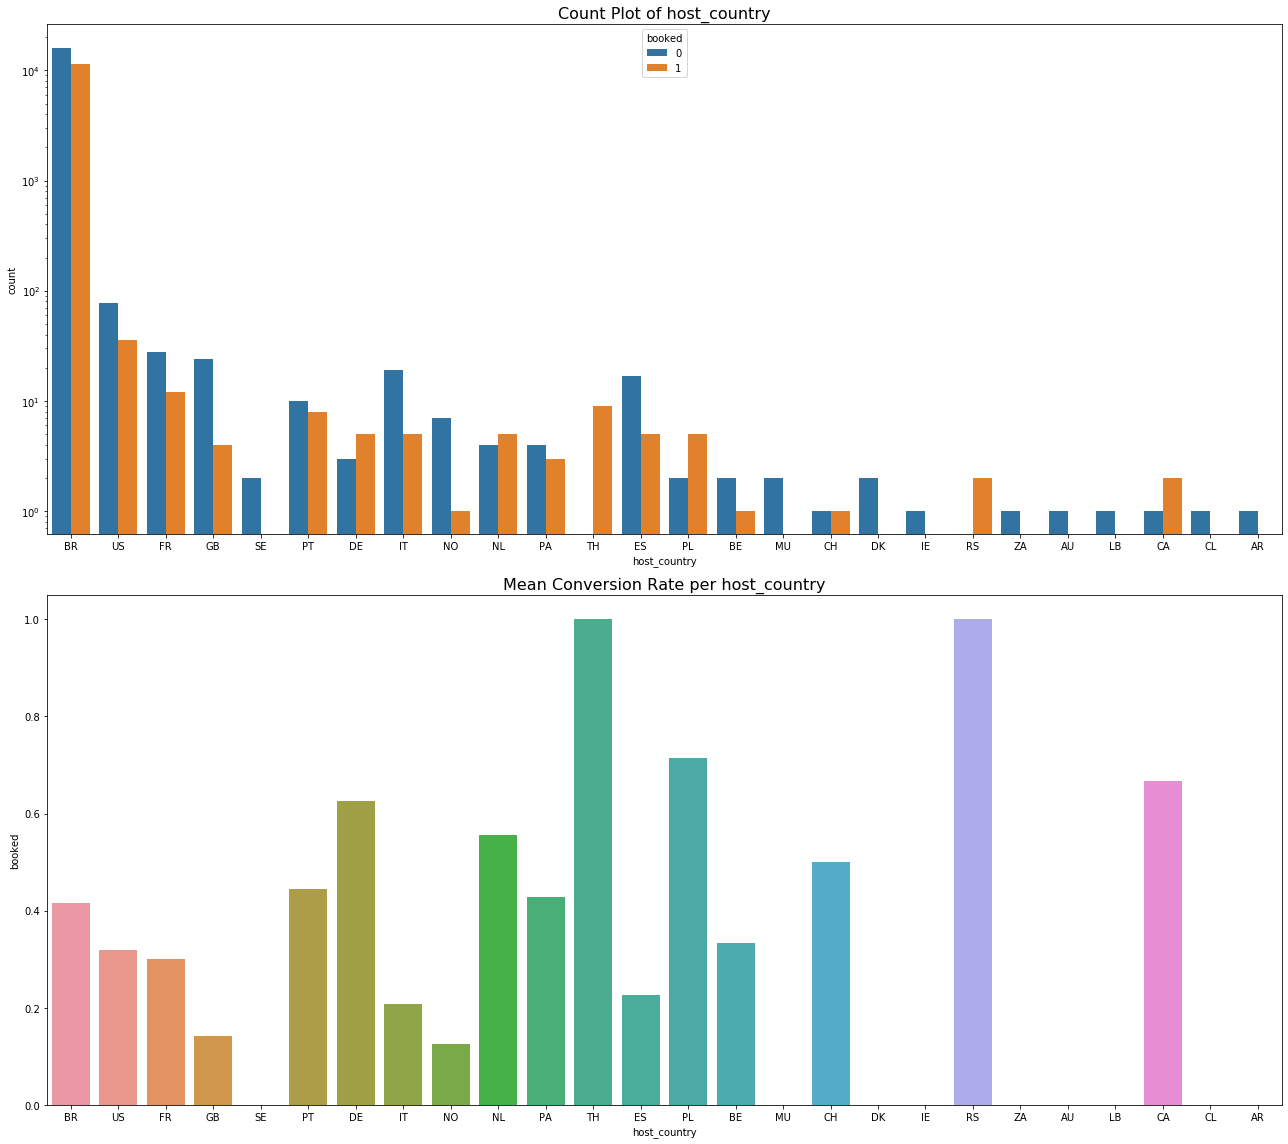

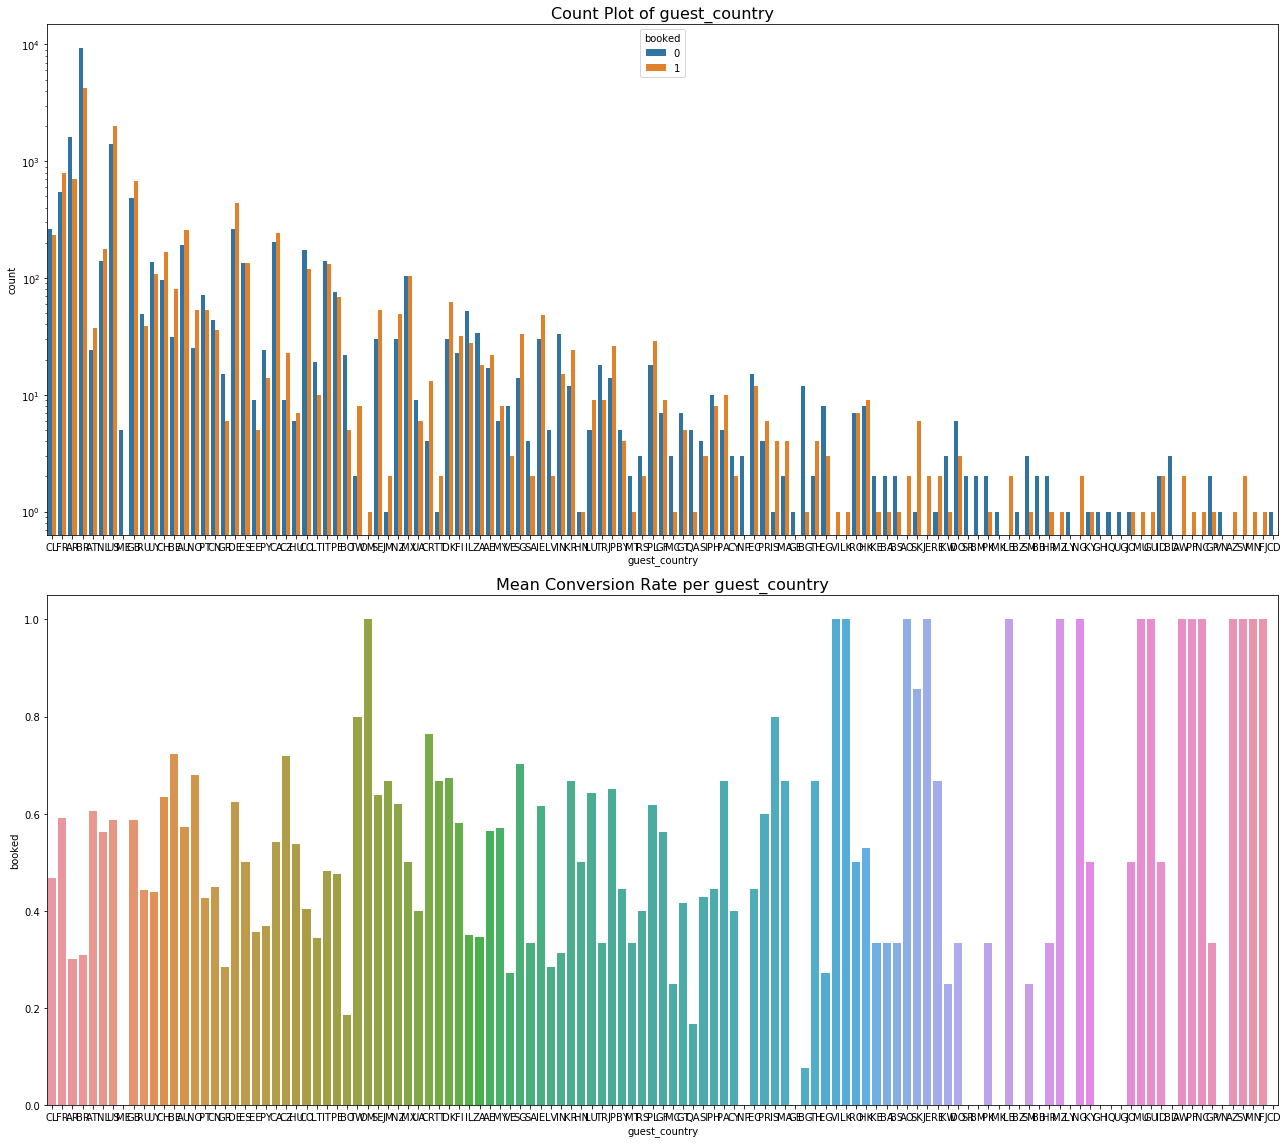

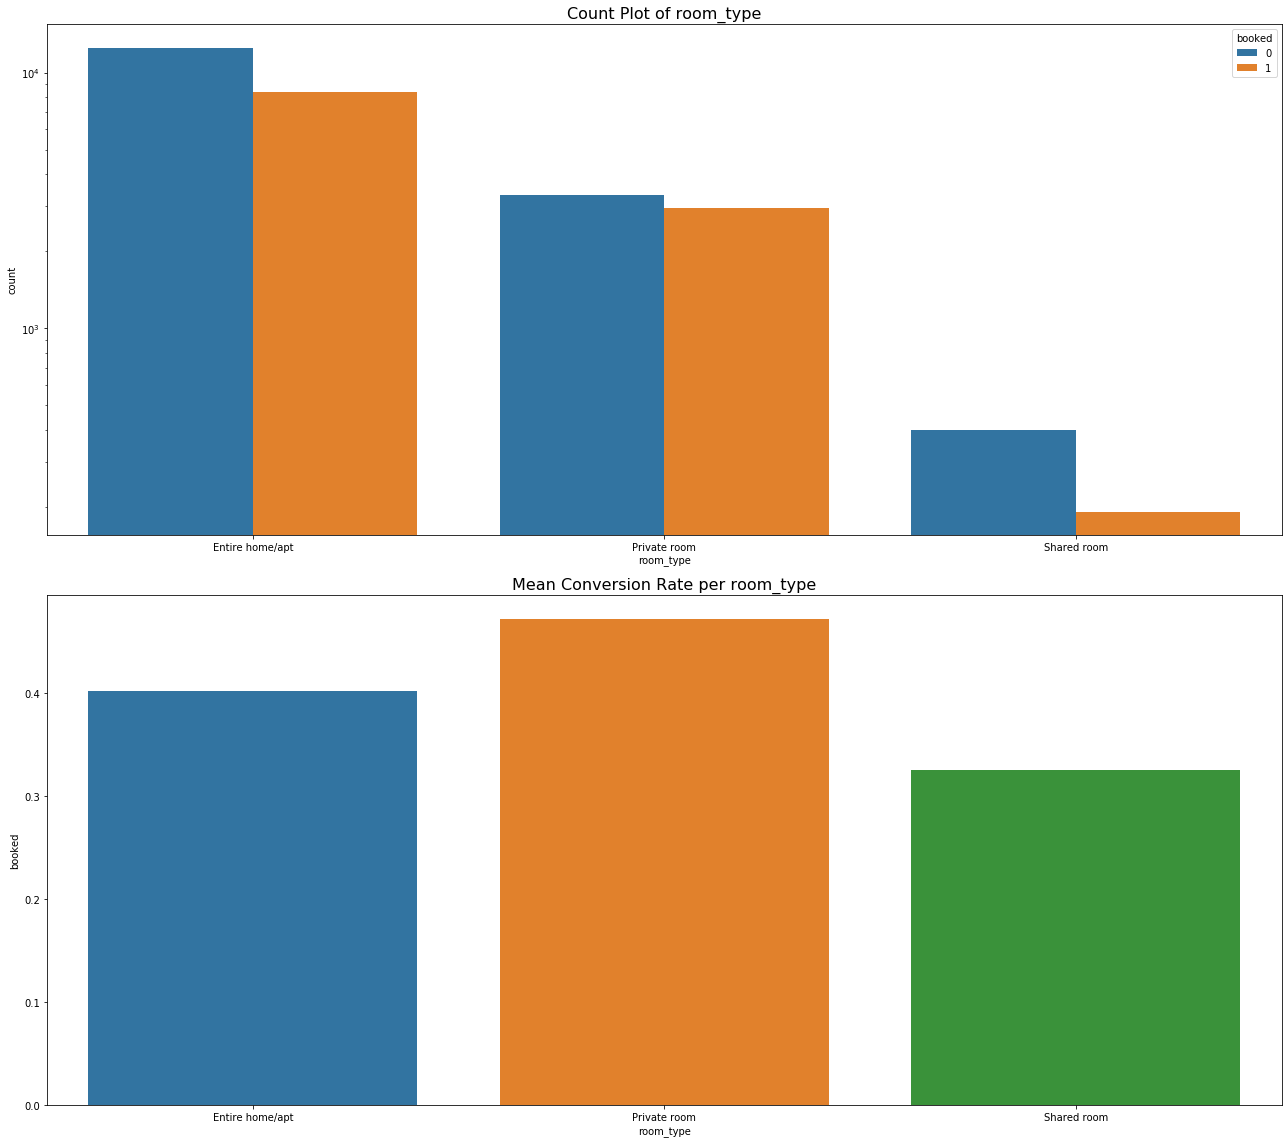

IndexError: too many indices for array

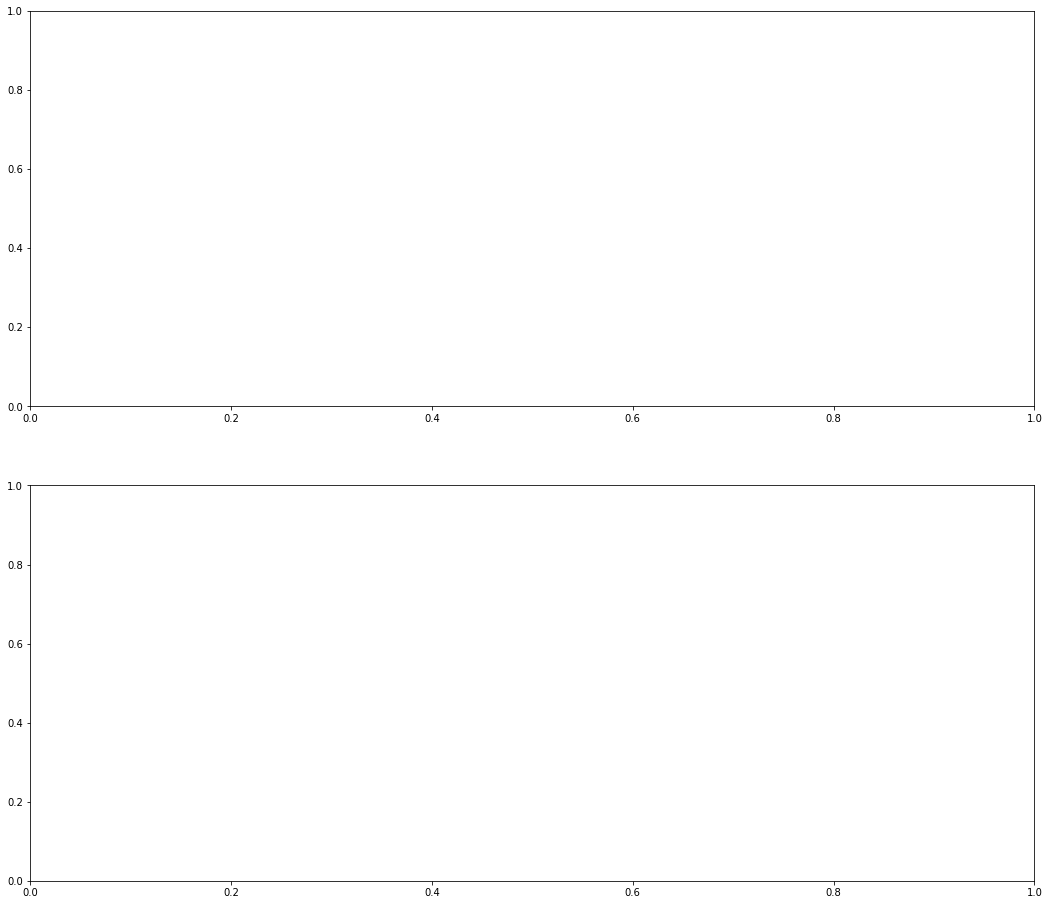

In [77]:
for cat in categorical_features:
    dist_count_plot(df_merged,cat,'booked')

### Continuous Features Plots

m_guests


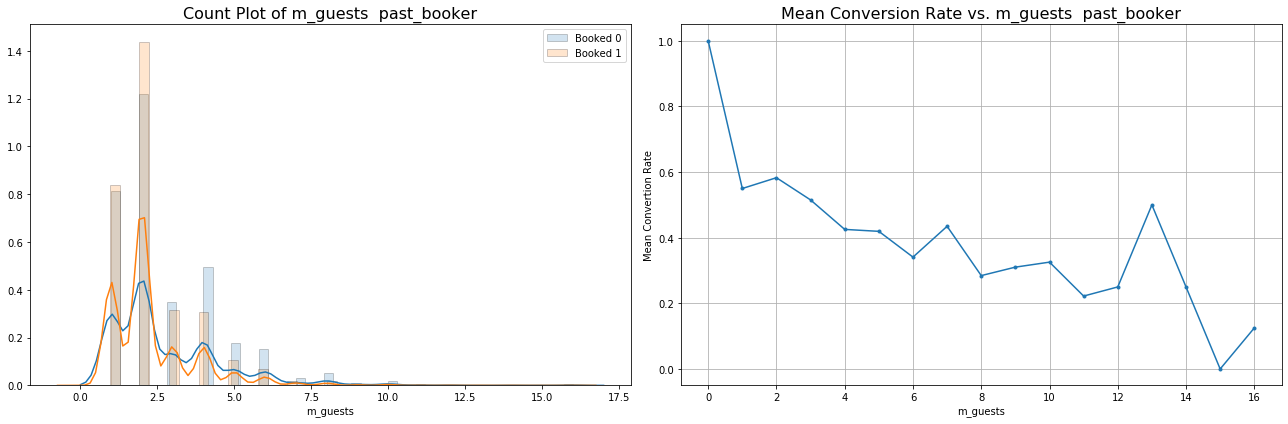

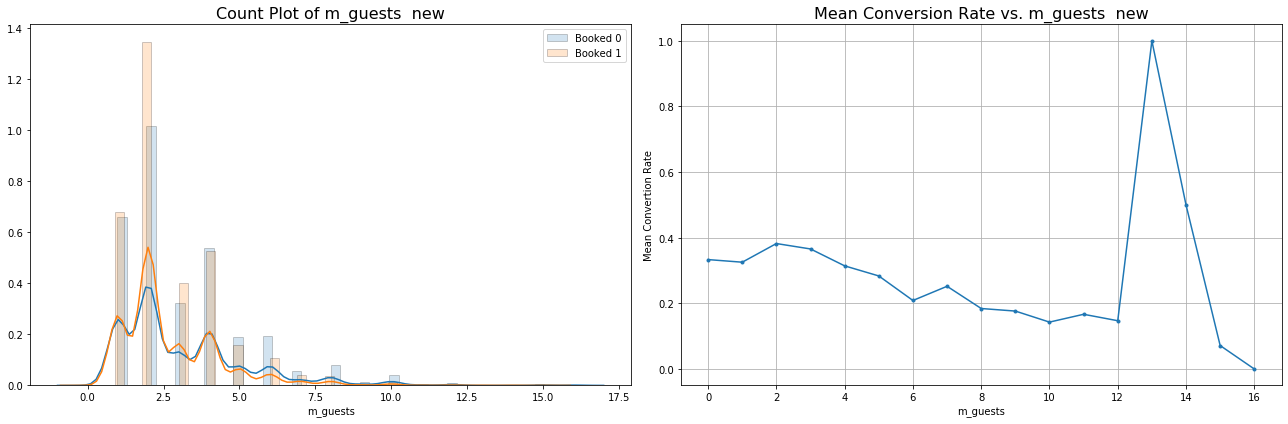

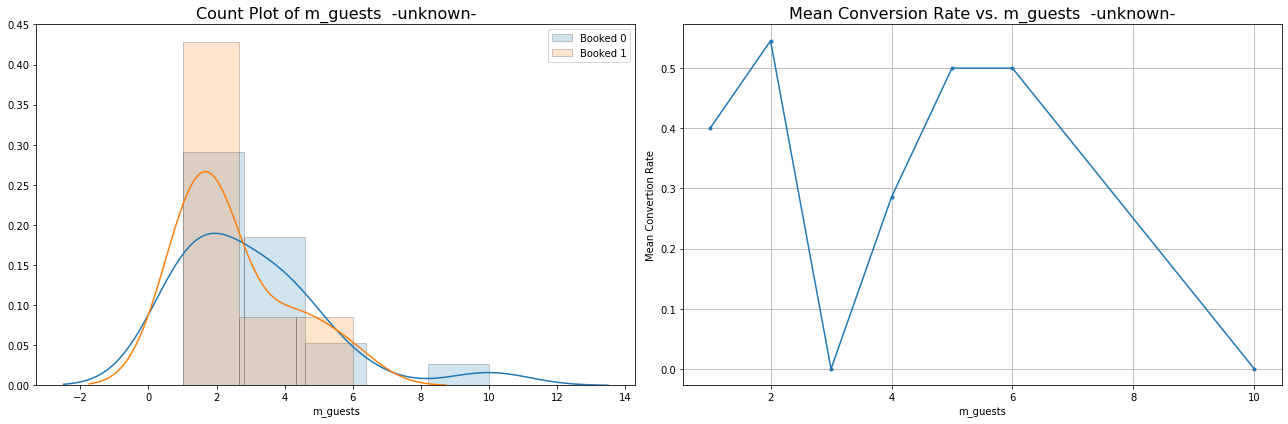

m_interactions


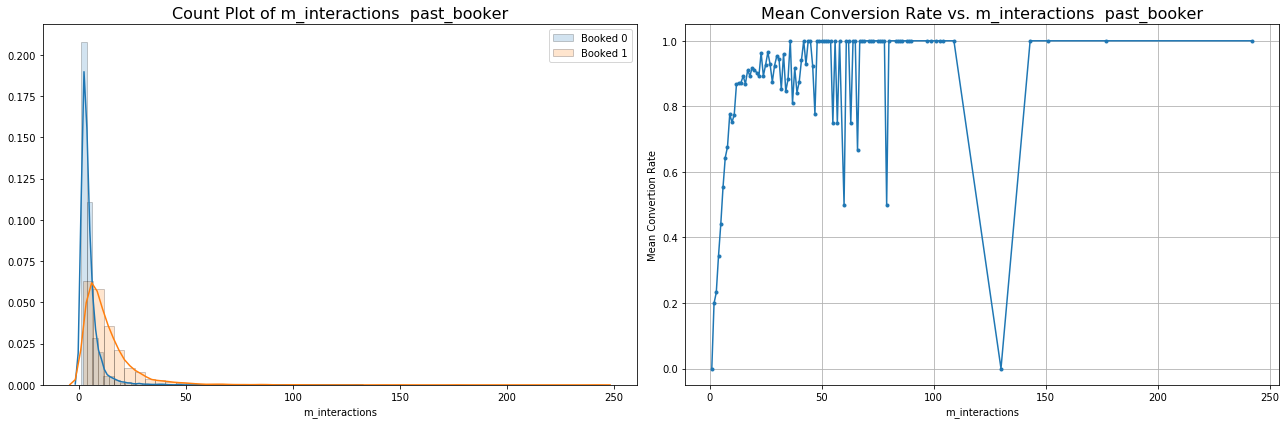

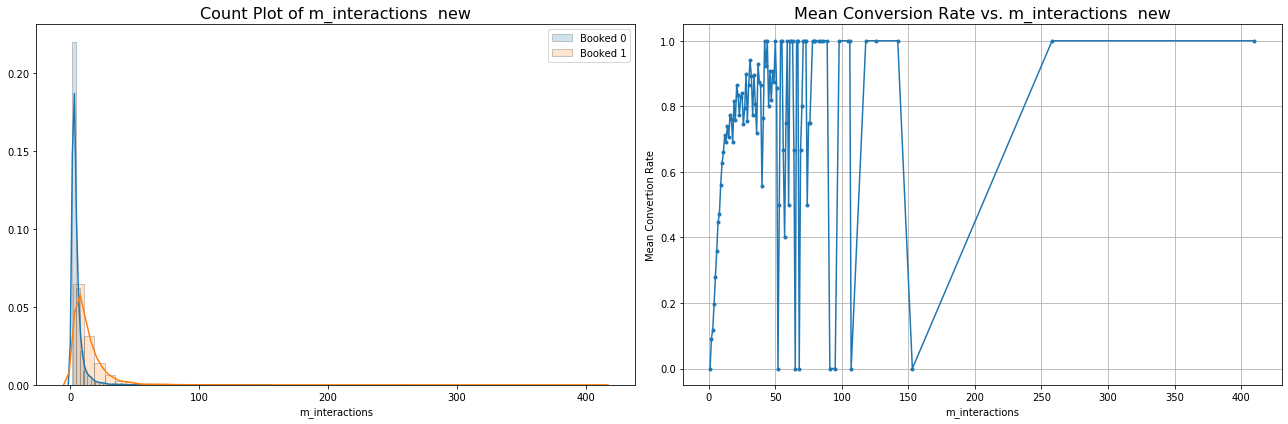

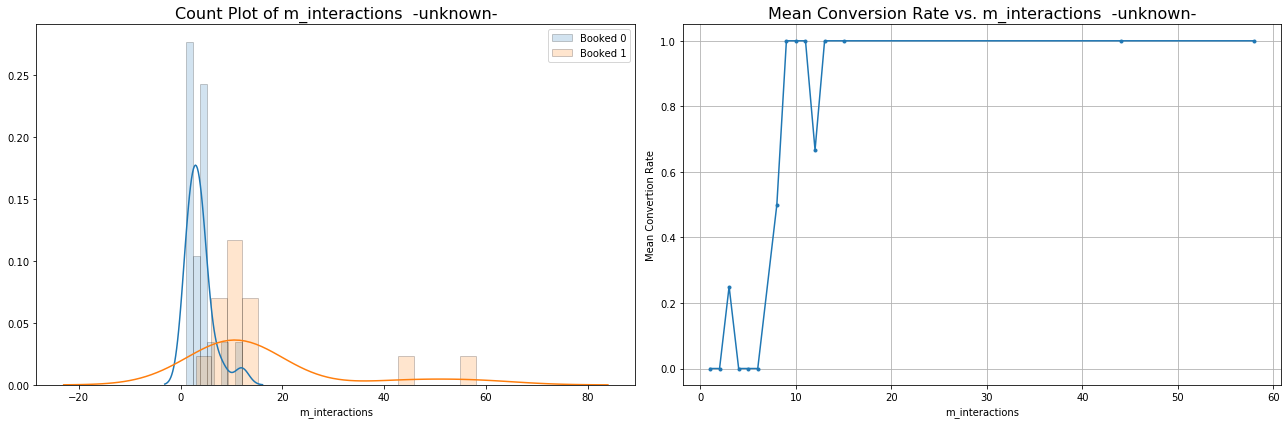

m_first_message_length_in_characters


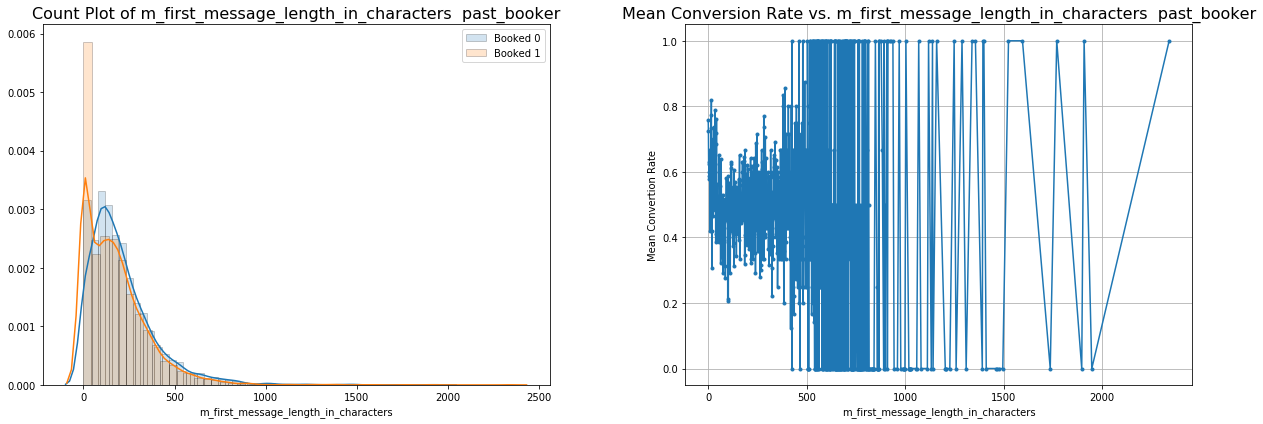

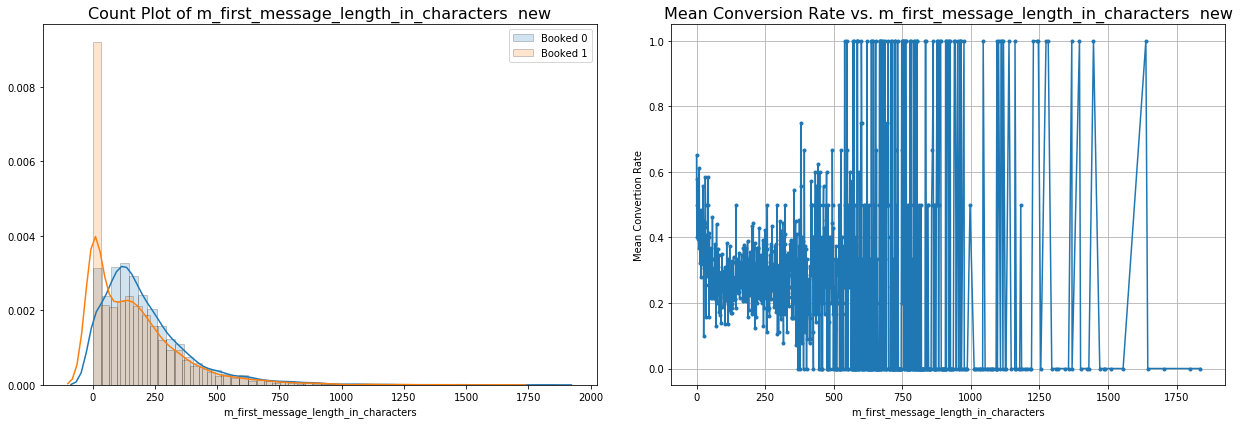

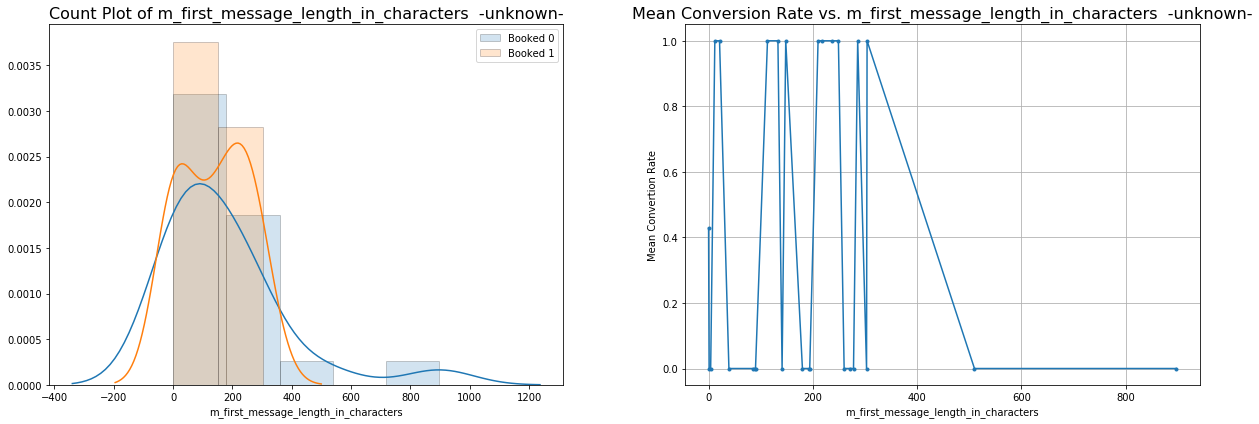

reply_inq_mins


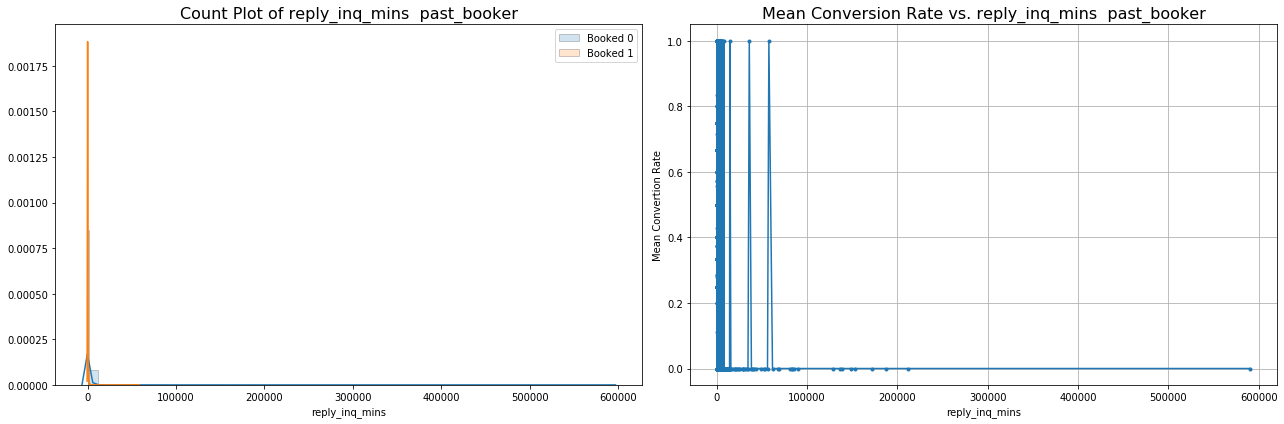

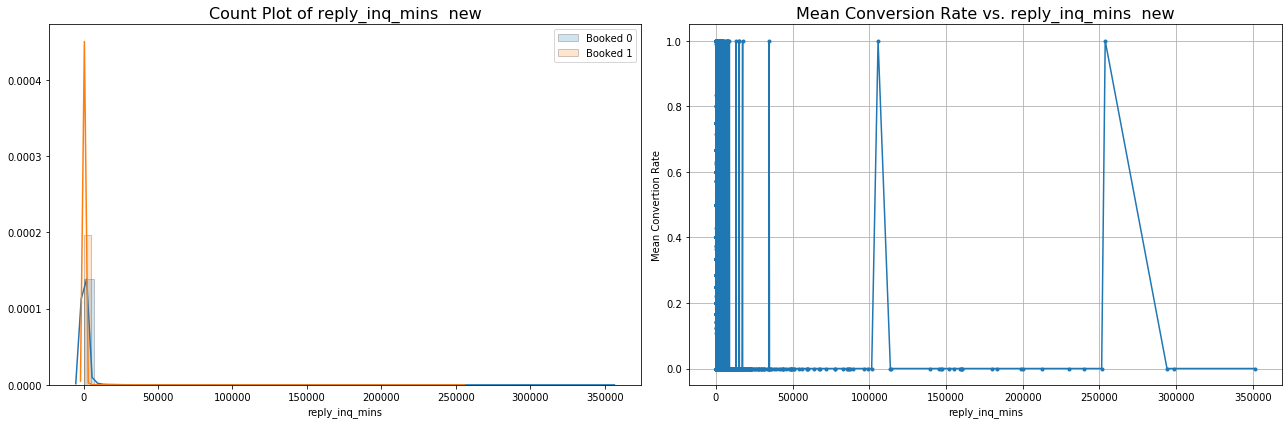

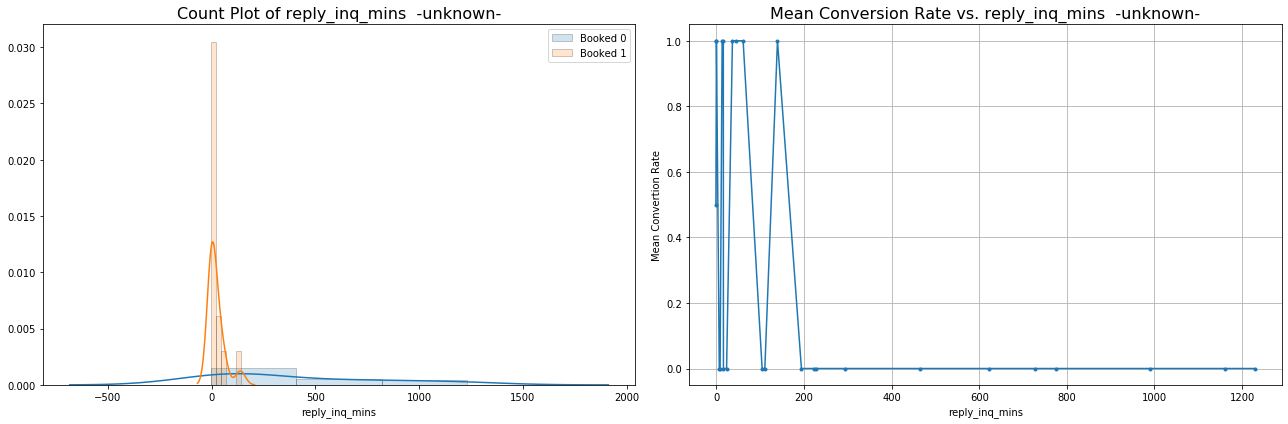

accept_inq_mins


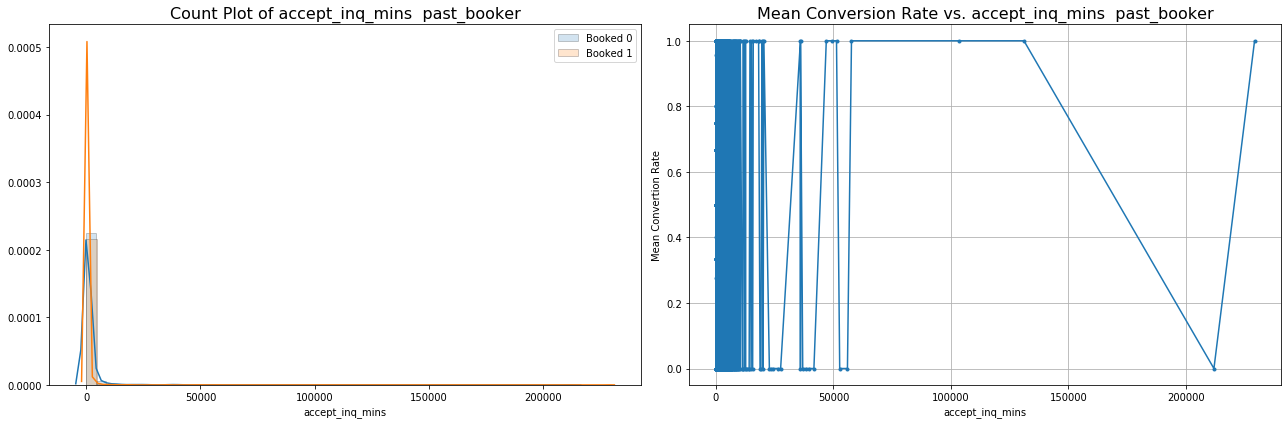

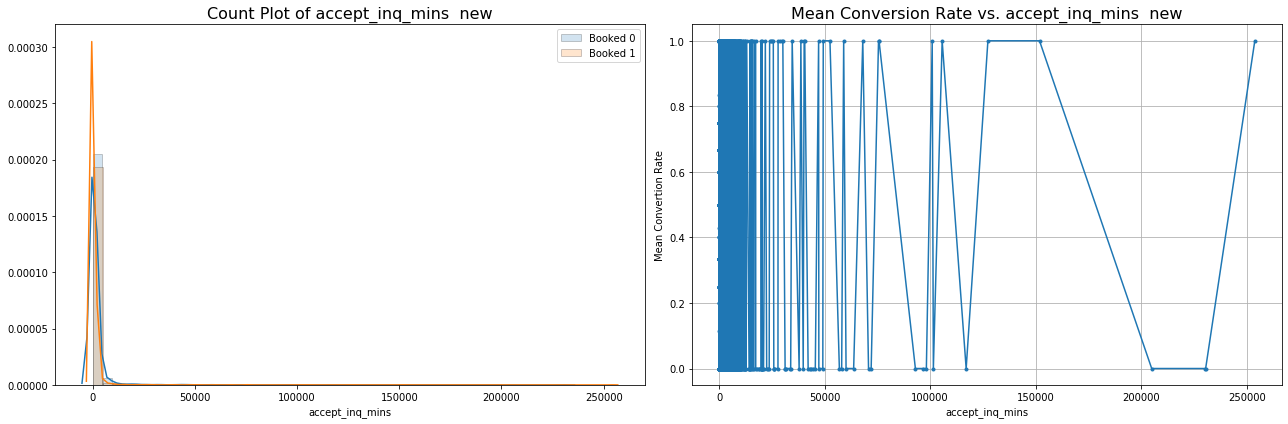

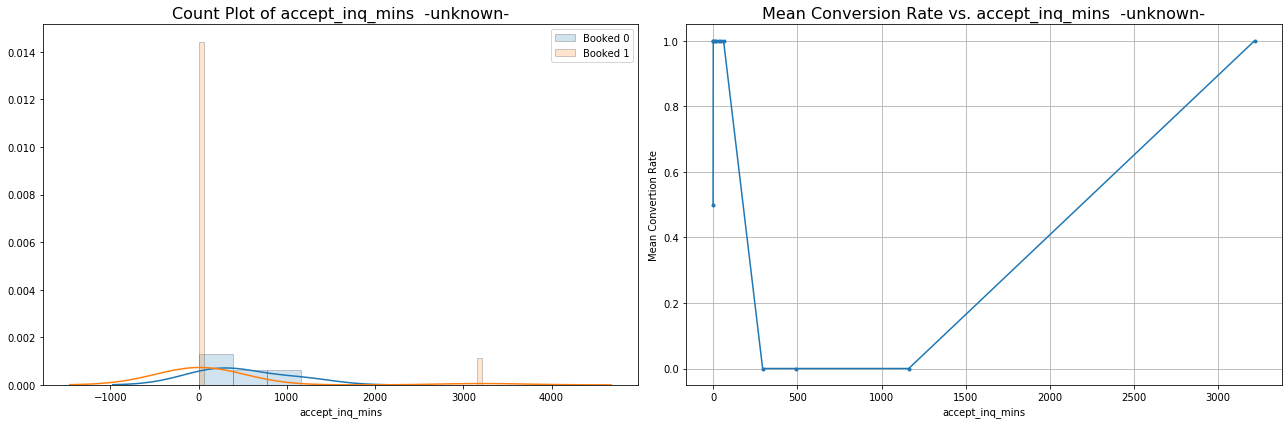

book_inq_mins


/anaconda2/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


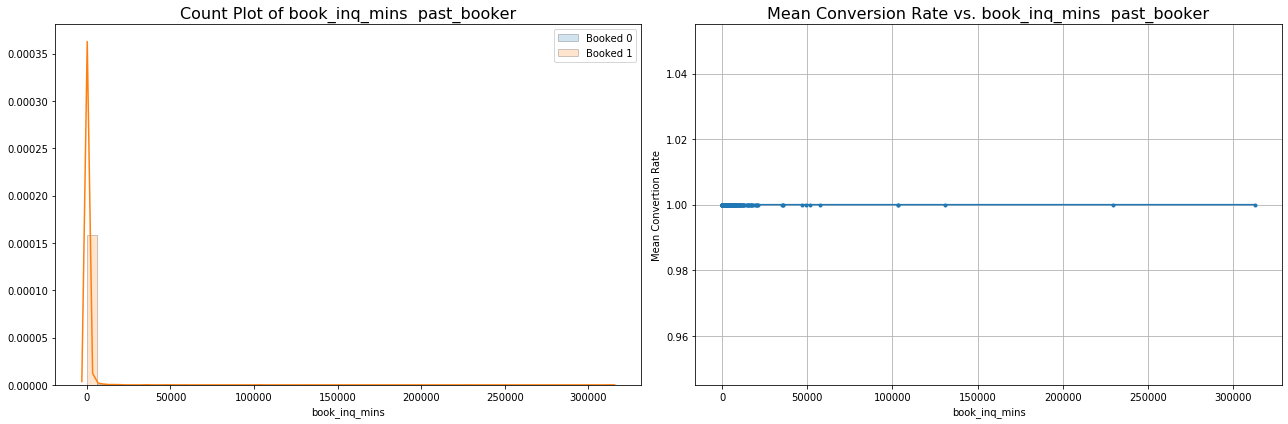

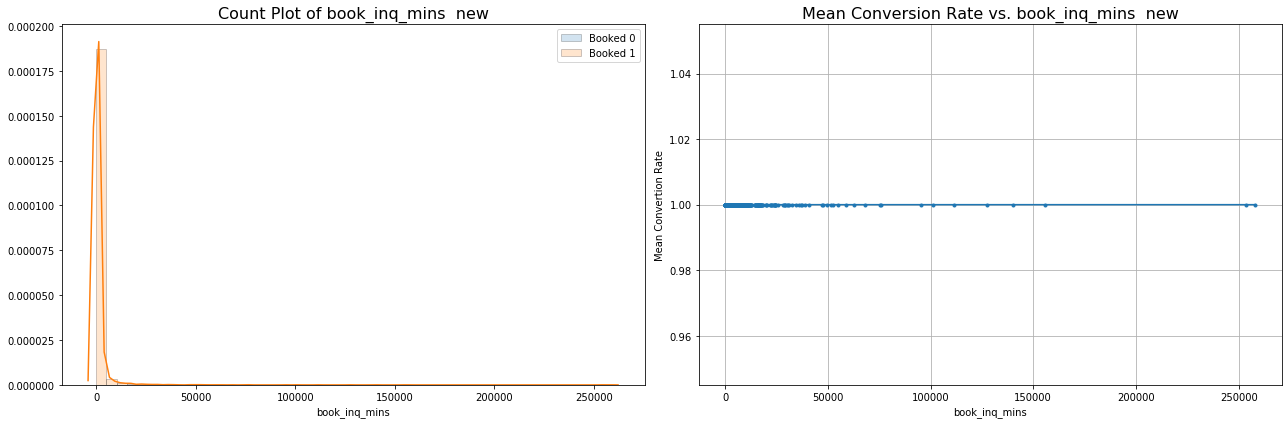

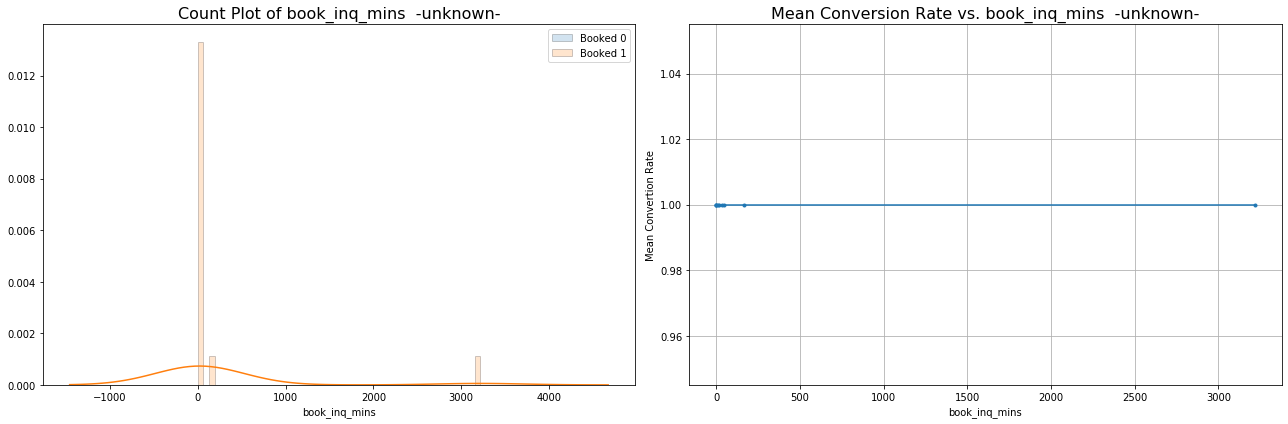

nights_stayed


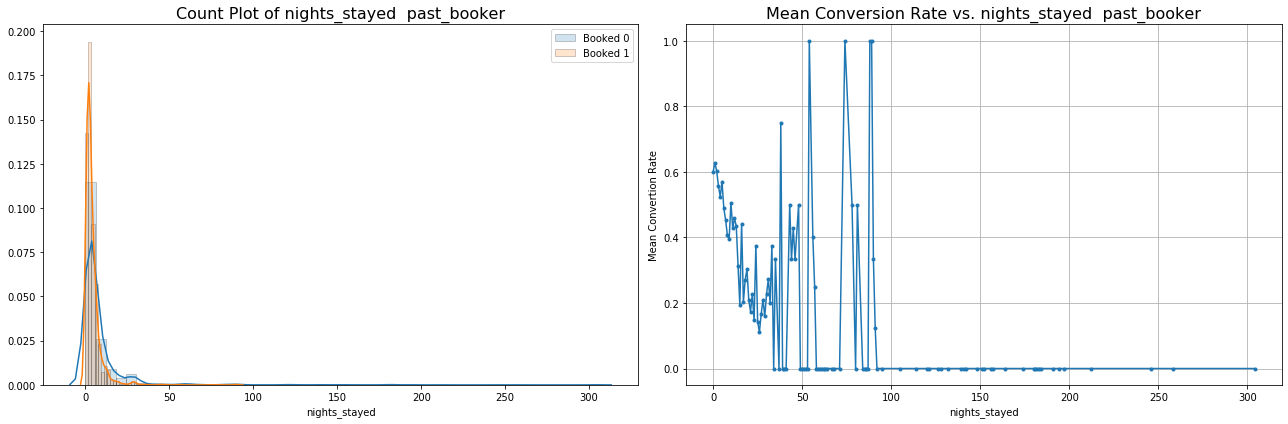

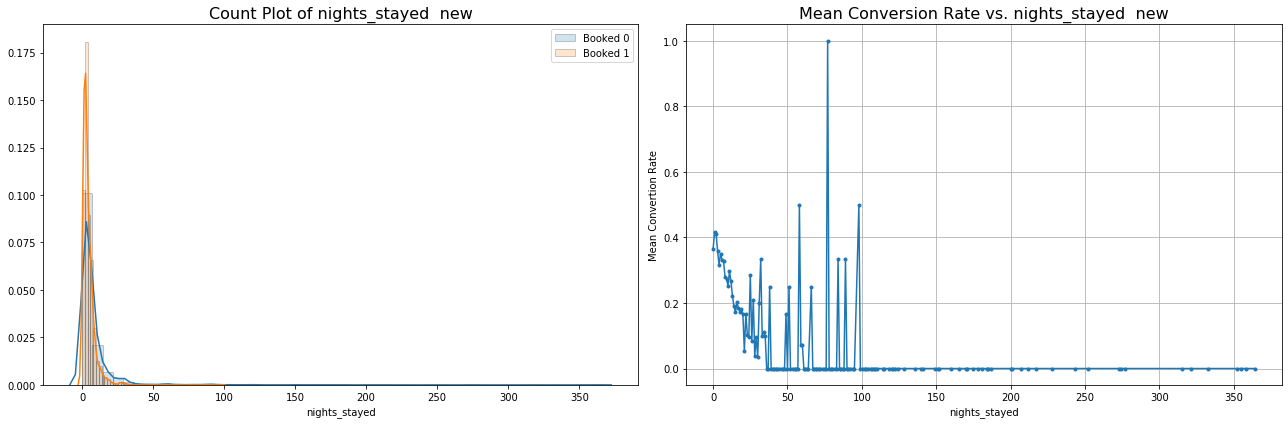

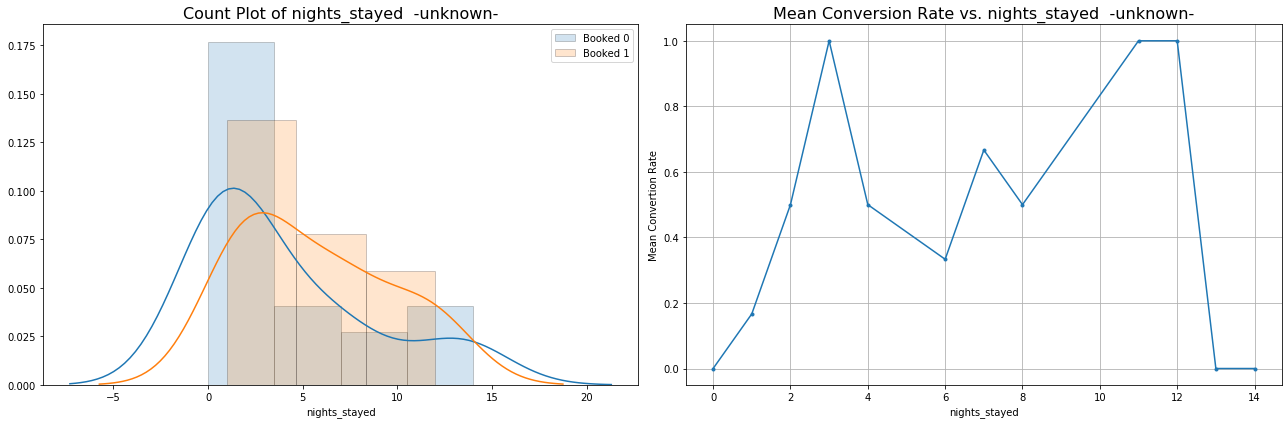

book_to_checkin


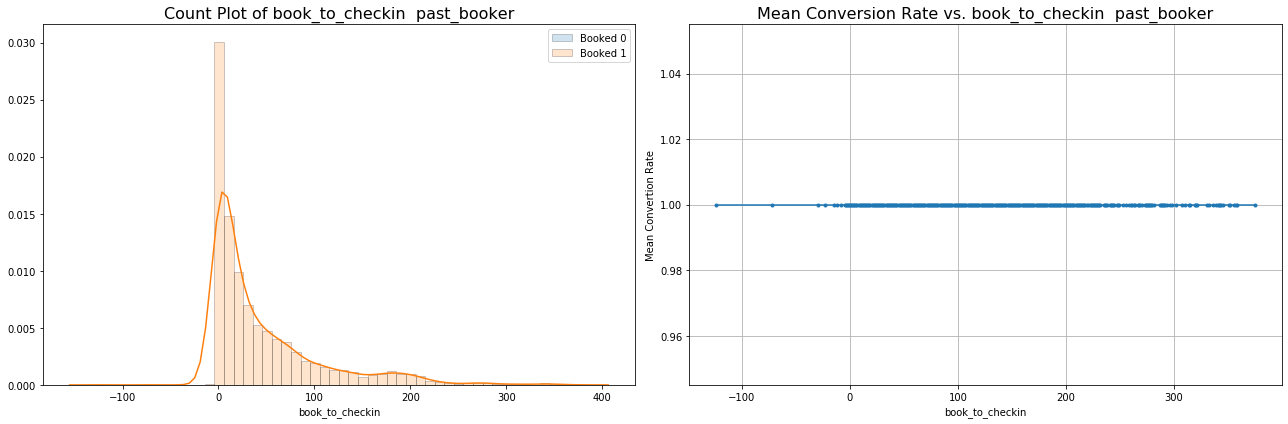

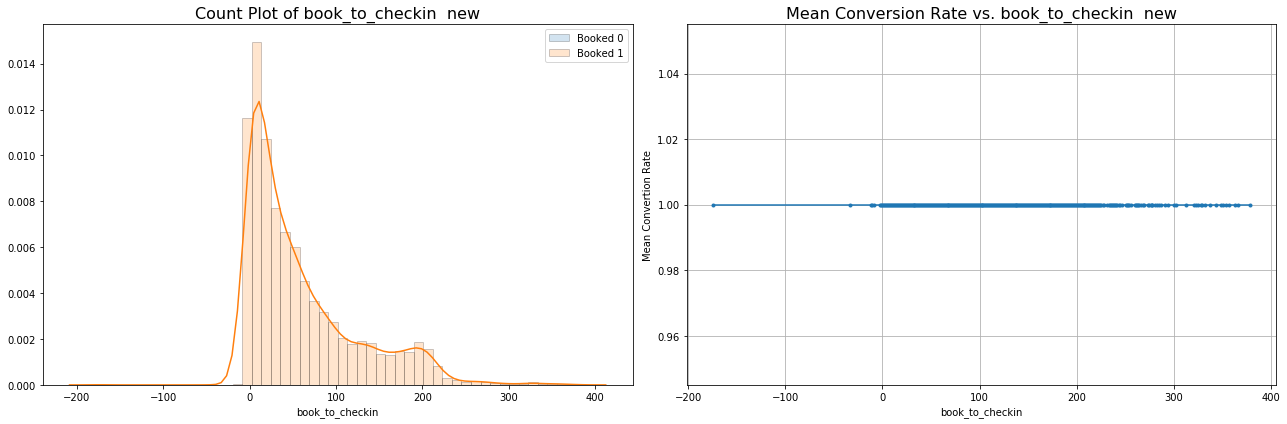

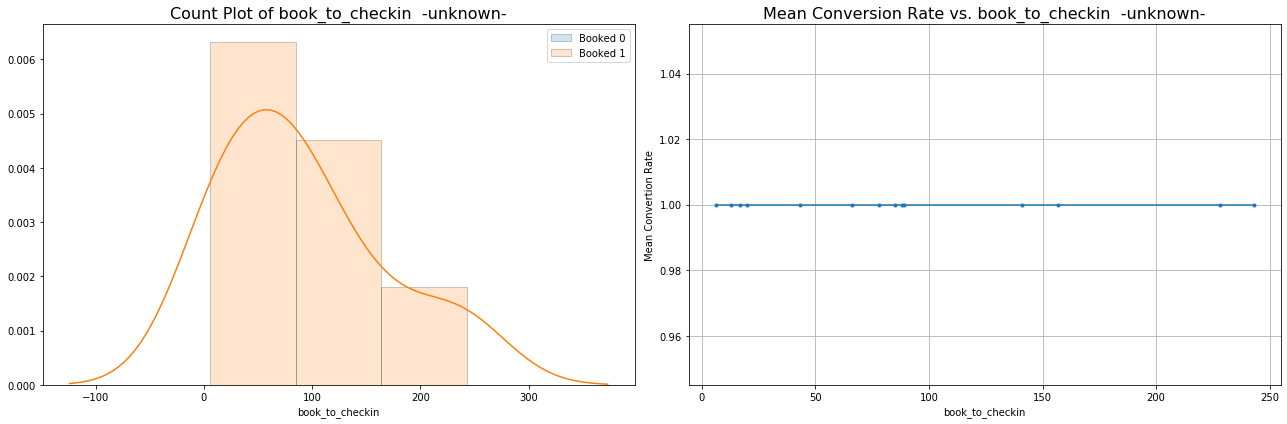

host_words_in_user_profile


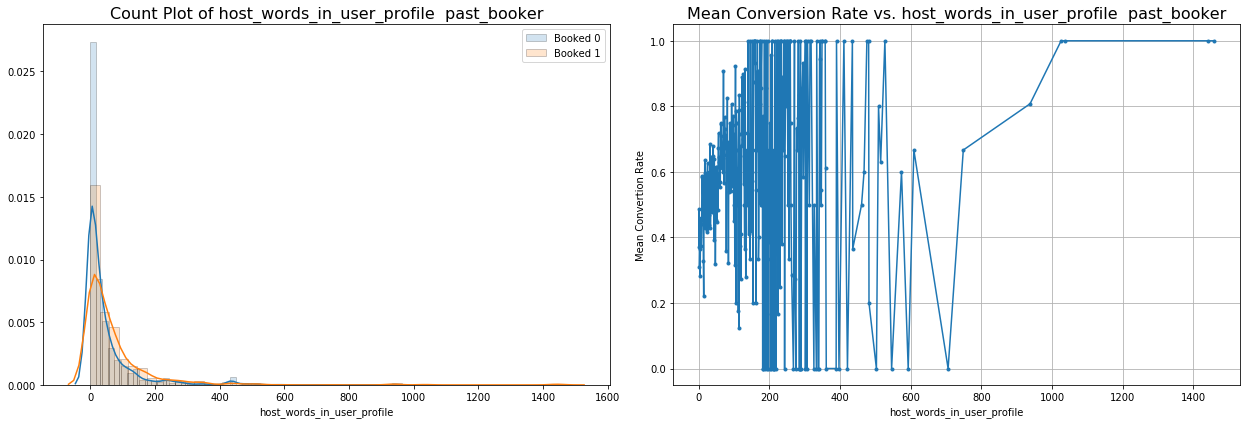

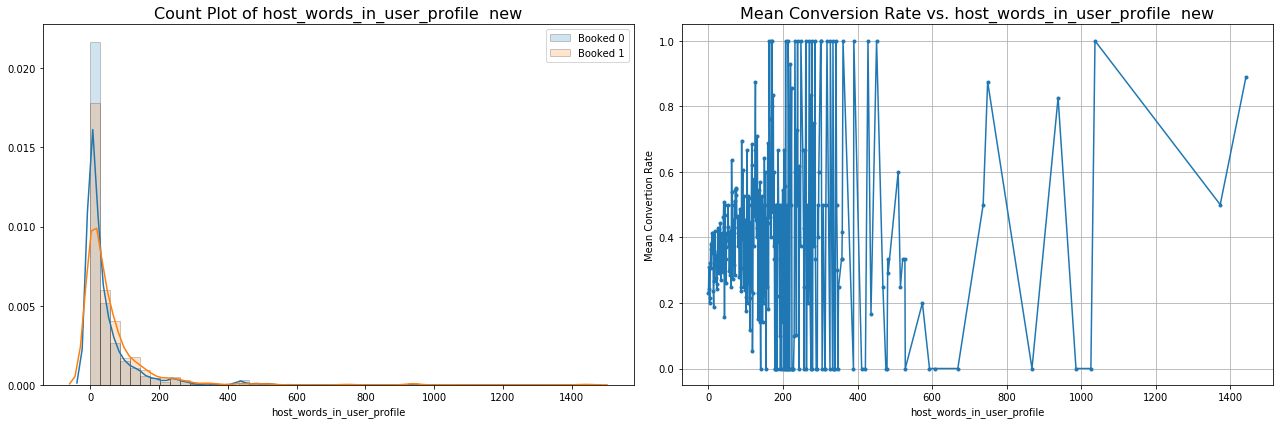

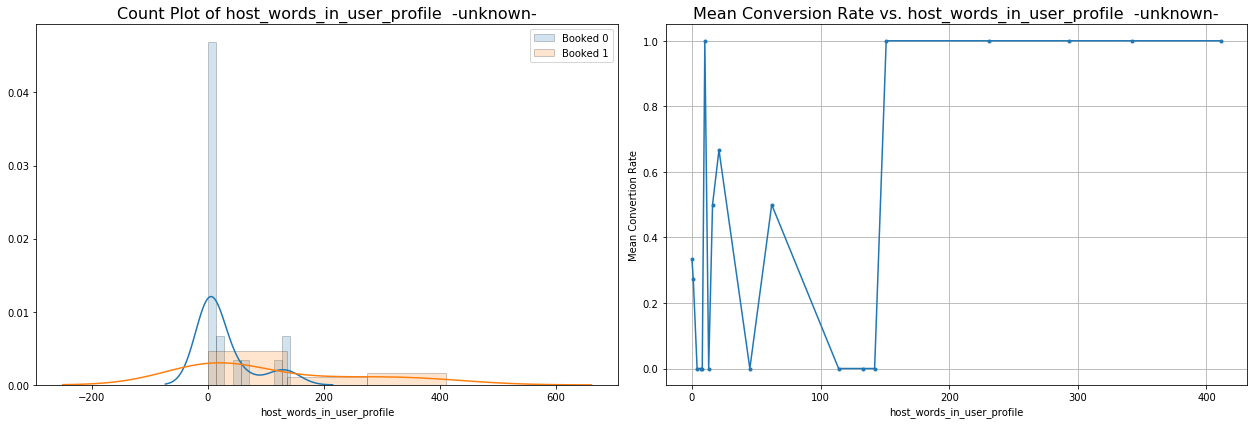

guest_words_in_user_profile


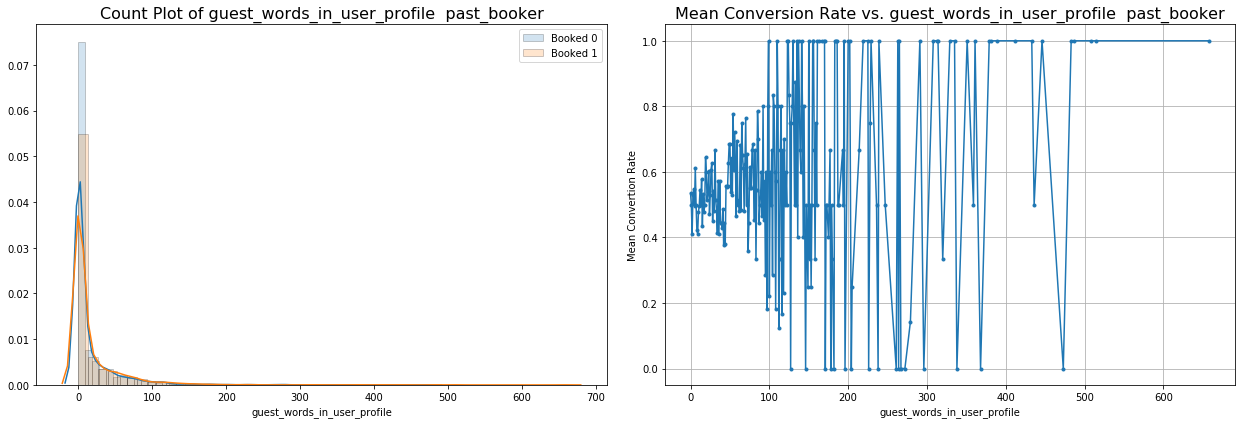

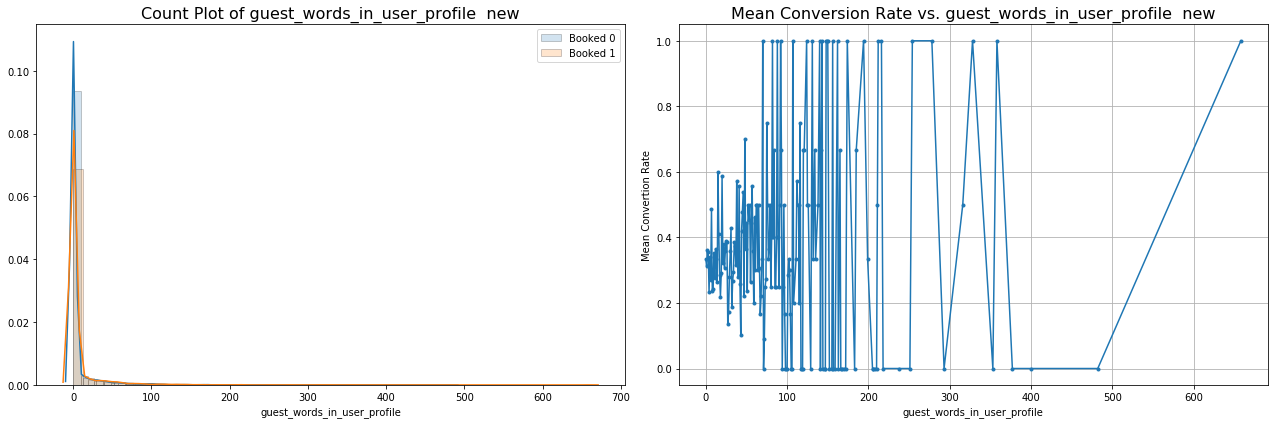

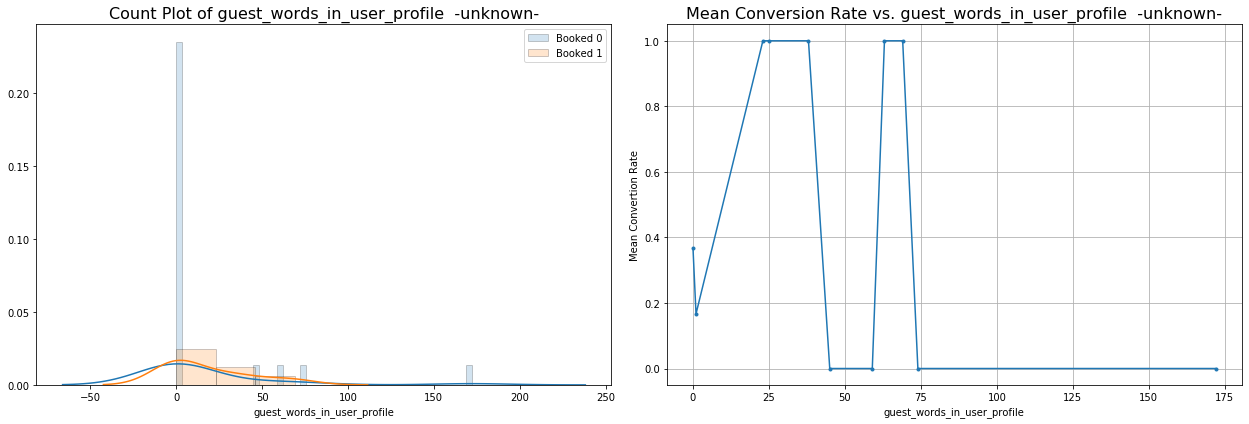

total_reviews


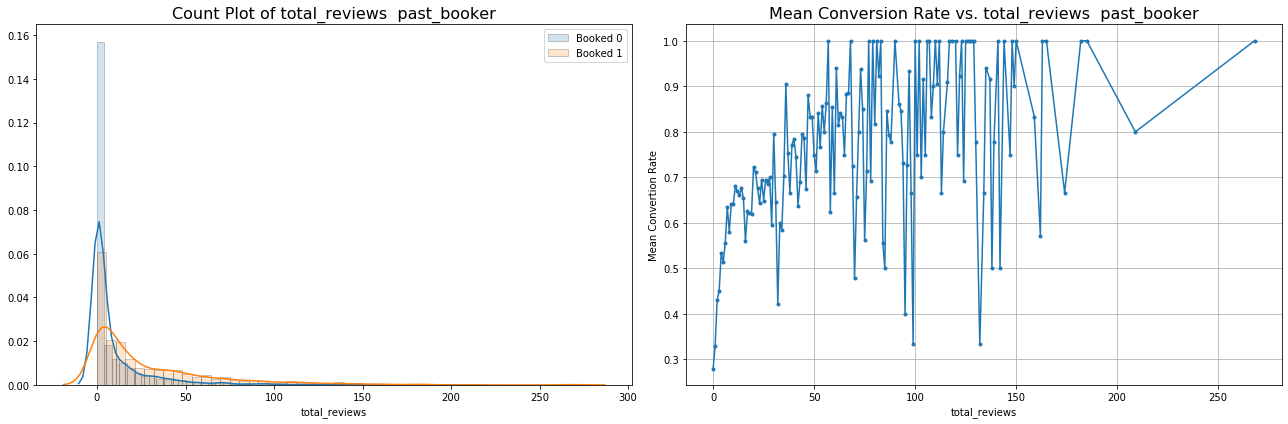

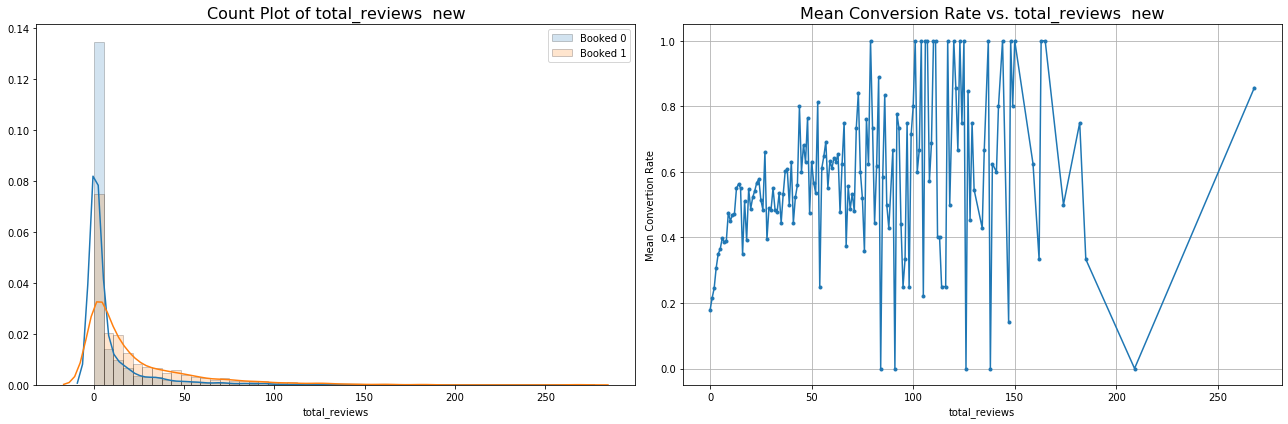

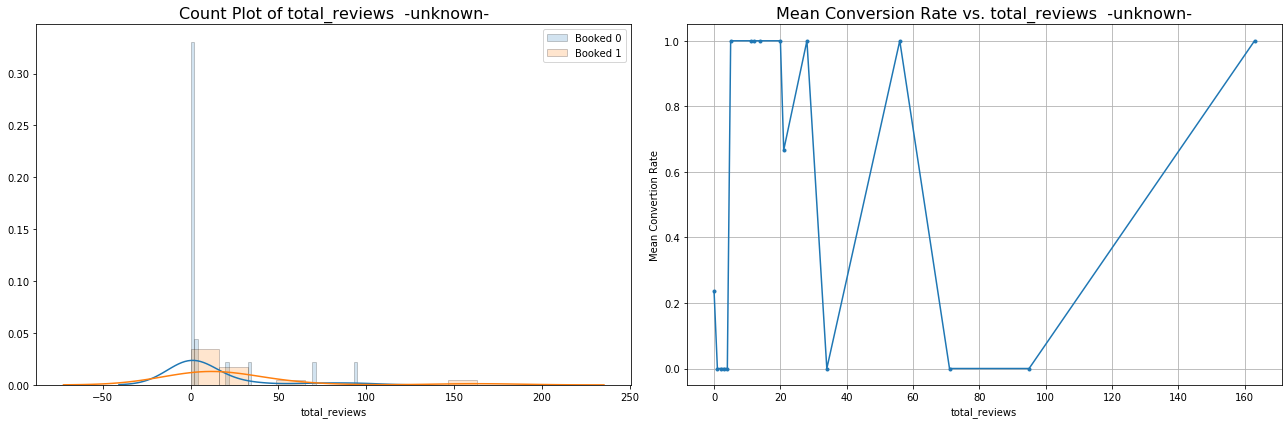

In [79]:
for cont in continuous_features:
    print (cont)
    dist_uni_plot(df_merged,cont,'booked',cohort='guest_user_stage_first')

### Data Cleaning

# TESTSTETSETSE


In [537]:
import logging

In [538]:
file_path = './data/'

In [648]:
logging.info('Importing data from: %s' % (file_path))

listings = pd.read_csv(os.path.join(file_path, 'listings.csv'))
users = pd.read_csv(os.path.join(file_path, 'users.csv'))
contacts = pd.read_csv(os.path.join(file_path, 'contacts.csv'))


In [649]:
isinstance(listings, pd.DataFrame)
isinstance(users, pd.DataFrame)
isinstance(contacts, pd.DataFrame)

True

In [650]:
n_samples, n_features = listings.shape
logging.info('Listing    # of Observations: %s' % (n_samples))
logging.info('Listing    # of Features: %s' % (n_features))
n_samples, n_features = users.shape
logging.info('Users    # of Observations: %s' % (n_samples))
logging.info('Users    # of Features: %s' % (n_features))
n_samples, n_features = contacts.shape
logging.info('Contacts    # of Observations: %s' % (n_samples))
logging.info('Contacts    # of Features: %s' % (n_features))

In [651]:
def convert_to_datetime(df, col):
    df[col] = np.where(df[col].notnull(),df[col],"")
    df[col] = [x.split('.',1)[0] for x in df[col]]
    df[col] = df[col].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != '' else '')

In [652]:
contacts.head(20)

id_guest_anon  \
0   da8656a1-51af-4f38-b1c4-94be1f585157   
1   8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37   
2   ebcd83ba-bda1-47eb-9680-2dd04ccf3988   
3   b0af8848-fe2a-4ef1-991e-26ab3066feb3   
4   5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2   
5   25940fca-7aa9-480d-9cf0-56cc1136d30c   
6   ee6633e1-96de-47f6-96e7-d962fc6db7dd   
7   b3357bab-cf20-4646-b723-23ae84fc8fb3   
8   e52ccc38-1ca1-48b4-a10a-08663601dbbb   
9   177cddfa-fe47-4668-81bf-884490a6707b   
10  8cb51614-2851-4d3d-93a6-620556ace3de   
11  b88f0944-8278-49c1-928c-eac65ca3a8d2   
12  a2c8d522-41df-4b49-9aaf-6c4b3d95afed   
13  c463ff6c-c2bf-474a-86c3-7fc979e08020   
14  0e07d4e8-2c3c-4848-b9dc-f7a859309e80   
15  255d7130-faea-4965-be56-96414335df6d   
16  bcd2c6bb-c5bf-484a-9cfc-ba13b8a0a9be   
17  e3939be4-b42e-40ec-a01e-e8d3c3a5be4f   
18  433f68eb-cf81-4d44-a15f-69c6f813a928   
19  b577b943-e463-4c5d-b762-c28b8cf2165f   

                            id_host_anon  \
0   5426897d-960d-4013-9e38-606ae746793c   
1   f30417c5-6df4-45ac-bfc2-6ad1cce398ab   
2   13cbf50a-3272-45d4-9866-a06b6ea1b99a   
3   01614601-d5a4-4776-ab9b-c10d3b865bf0   
4   f2fed6f3-4c5c-453d-9e64-37c62b8bd06d   
5   90334ef3-f489-45a0-89e0-d18d370e4a1c   
6   10dc3fc4-694f-44b2-aaac-9dbace0ebabd   
7   7e0696cb-6321-4d60-a8e9-793ee14724fd   
8   1c990fca-5b09-4eca-bdcf-d9e923112f04   
9   2bd81140-3d71-4fd9-add3-5998f9263c57   
10  7a7c50a7-2a19-44a7-ab5c-b2b658ebcf8b   
11  bf6e95ec-966d-46af-9bfe-f2dd91523571   
12  3d046d4c-b456-4fdc-b1db-9ee1a7a441a9   
13  a66f8d54-84ac-4220-9296-a5037370a5b6   
14  e540b776-3f0f-498b-ad8a-a0ecc54df286   
15  efa7ea8b-e78c-48d1-abfd-1dfc06c48e61   
16  d5bcd535-92a1-4337-9148-6b53ce87c311   
17  90b34959-9aaa-40d9-9874-439f12d3acd8   
18  af7f1101-3b5d-4e45-822a-0a2fd1dcf4bb   
19  e086d187-8e1e-4810-9f74-d3204043601c   

                         id_listing_anon   ts_interaction_first  \
0   a408a8b2-0d44-4513-a611-3736d0409bb2    2016-04-21 02:55:53   
1   e387c705-0aeb-464c-9375-ece63be6f006    2016-02-16 22:14:01   
2   d1eb1960-938f-4305-a353-51e224414dd4    2016-01-27 23:33:38   
3   855f6779-346c-45fc-a64b-ea133250ca7a    2016-05-05 14:42:52   
4   f2928a59-c5e7-42b2-9c37-240a40f38dc0  2016-06-23 03:09:25.0   
5   5dd24057-774c-45b3-b305-ebf664246952    2016-04-19 07:08:21   
6   259d4a6c-dcda-4ff2-85cb-2882f6801b3a    2016-05-30 15:16:21   
7   75de5296-f7df-45d2-9c18-af332a082784  2016-03-10 12:13:46.0   
8   f6822854-6d3c-4cfd-a983-49603a401771  2016-04-24 06:46:42.0   
9   cff02e60-1205-42fa-afd4-0c23029ce32e    2016-04-26 02:11:47   
10  472ead4a-63a3-422e-8c98-1745f773e2c0    2016-01-10 18:09:45   
11  1f51882a-4abd-4bd4-be6d-a75ae8be4986    2016-06-03 22:40:22   
12  96169363-f4e6-4a15-8a2f-90d93c6ae469    2016-02-20 03:51:52   
13  64930c5b-232a-4c93-af86-fe8e8dfc276c    2016-02-28 18:03:02   
14  efbd8ae0-75e5-4d05-be3a-1c150ce3a9fd    2016-04-13 07:37:53   
15  4c1011e5-da80-4c45-a5f9-a5ae9ff4e58f    2016-01-06 18:58:31   
16  7e367f14-45a8-4a7c-a328-3e151cf71fed    2016-01-07 06:12:42   
17  ed510d46-74ec-4870-9024-48f29ff12bad    2016-01-20 15:14:21   
18  a3722b1e-fd37-4fa0-a7b7-8e10b1eda61e    2016-01-24 20:54:34   
19  eb4799d5-aa04-4402-9bec-9625f6700e4e  2016-05-19 12:27:11.0   

        ts_reply_at_first   ts_accepted_at_first          ts_booking_at  \
0   2016-04-21 03:15:00.0  2016-04-21 03:15:00.0  2016-04-21 03:15:00.0   
1   2016-02-16 23:37:36.0                    NaN                    NaN   
2   2016-01-28 02:12:47.0                    NaN                    NaN   
3   2016-05-05 15:17:40.0  2016-05-05 15:17:40.0                    NaN   
4   2016-06-23 03:09:26.0  2016-06-23 03:09:33.0  2016-06-23 03:09:33.0   
5   2016-04-19 11:32:23.0                    NaN                    NaN   
6   2016-05-30 15:18:55.0  2016-06-01 23:38:20.0                    NaN   
7   2016-03-10 12:13:47.0  2016-03-10 12:13:47.0  2016-03-10 12:13:47.0   
8   2016-04-24 06:46:42.0  2016-04-24 06:46:42.0  2016-04-24 06:46:42.0   
9   2016-04-26 02:1

In [653]:
#Convert timestamps to datetime in Contacts
logging.info('Convert timestamps to datetime in Contacts table')
for col_ts in ['ts_interaction_first','ts_reply_at_first','ts_accepted_at_first','ts_booking_at']:
    convert_to_datetime(contacts, col_ts)
contacts['ds_checkin_first'] = contacts['ds_checkin_first'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
contacts['ds_checkout_first'] = contacts['ds_checkout_first'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [654]:
#Length of time a host takes to reply to an inquiry (minutes)
logging.info('Adding Feature: reply_inq_mins: Length of time(minutes) host replies to inquiry')
contacts['reply_inq_mins'] = (contacts['ts_reply_at_first']-contacts['ts_interaction_first']).apply(lambda x: x.total_seconds())/60

#Length of time for host to accept an inquiry (minutes)
logging.info('Adding Feature: accept_inq_mins: Length of time(minutes) host takes to accept an inquiry')
contacts['accept_inq_mins'] = (contacts['ts_accepted_at_first']-contacts['ts_interaction_first']).apply(lambda x: x.total_seconds())/60

#Length of time for host to accept booking from inquiry(minutes)
logging.info('Adding Feature: book_inq_mins: Length of time(minutes) to confirm booking from inquiry')
contacts['book_inq_mins'] = (contacts['ts_booking_at']-contacts['ts_interaction_first']).apply(lambda x: x.total_seconds())/60

#identifier that the contact lead to a booking (0=failed, 1=succeeded)
logging.info('Adding Feature: booked: User successfully booked an Airbnb')
bookings = []
for book in contacts['ts_booking_at']:
    if book is pd.Timestamp('NaT'):
        bookings.append(0)
    else:
        bookings.append(1)
contacts['booked'] = bookings

#Length of stay
logging.info('Adding Feature: num_nights: Number of nights requested')
contacts['num_nights'] = (contacts['ds_checkout_first']-contacts['ds_checkin_first']).apply(lambda x: x.days-1)

#length of time between check-in date and inquiry date
logging.info('Adding Feature: inq_to_checkin: Length of time(days) between inquiry and check-in date')
contacts['inq_to_checkin'] = (contacts['ds_checkin_first']-contacts['ts_interaction_first']).apply(lambda x: x.days)

#get day of week for check in date (Mon=0, Tues=1 ... Sun=6)
logging.info('Adding Feature: checkin_day_of_week: Check-in Day of Week (Mon=0, Tues=1...Sun=6)')
contacts['checkin_day_of_week'] = contacts['ds_checkin_first'].apply(lambda x: x.weekday())

In [661]:
#Merge datasets
logging.info('Merge Users and Contacts Table')
df = contacts.merge(
    users,
    right_on='id_user_anon',
    left_on='id_host_anon',
    how='left').merge(
            users,
            right_on='id_user_anon',
            left_on='id_guest_anon',
            how='left')

In [662]:
logging.info('Merge Listings and Merged Table')
df = df.merge(listings,on='id_listing_anon',how='left')

In [664]:
#Clean column names
logging.info('Clean columns')
del df['id_user_anon_x']
del df['id_user_anon_y']
df.columns = ['id_guest_anon', 'id_host_anon', 'id_listing_anon',
       'ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first',
       'ts_booking_at', 'ds_checkin_first', 'ds_checkout_first', 'm_guests',
       'm_interactions', 'm_first_message_length_in_characters',
       'contact_channel_first', 'guest_user_stage_first', 'reply_inq_mins',
       'accept_inq_mins', 'book_inq_mins', 'booked', 'num_nights',
       'inq_to_checkin', 'checkin_day_of_week',  'host_country',
       'host_words_in_user_profile', 'guest_country',
       'guest_words_in_user_profile', 'room_type', 'listing_neighborhood',
       'total_reviews']

In [ ]:
n_samples, n_features = df.shape
logging.info('Contacts    # of Observations: %s' % (n_samples))
logging.info('Contacts    # of Features: %s' % (n_features))

In [672]:
#Check and drop duplicates
logging.info('Number of duplicate rows: %s' % (df.duplicated().sum()))
df.drop_duplicates(inplace=True)

In [709]:
#Check number of null or NaT values in each column
col_null = {}
for col in df.columns:
    if df[col].dtype == np.dtype('<M8[ns]'):
        num_null = len([x for x in df[col] if x is pd.Timestamp('NaT')])
        if num_null > 0:
            logging.warn('%s null values found in column: %s' % (num_null, col))
            col_null[col] = num_null
    else:
        num_null = df[col].isnull().sum()
        if num_null > 0:
            logging.warn('%s null values found in column: %s' % (num_null, col))
            col_null[col] = num_null

/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  import sys
/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  if sys.path[0] == '':


In [706]:
#Drop nulls if safe
logging.info('Dropping Nulls if safe to')
for col in col_null.keys():
    if col_null[col] < 15:
        df = df[pd.notnull(df[col])]
        df = df.reset_index(drop=True)

In [724]:
# Convert # of guests to int
df['m_guests'] = df['m_guests'].astype(int)

# Convert # of first message length to int
df['m_first_message_length_in_characters'] = df['m_first_message_length_in_characters'].astype(int)

# Convert # of total reviews to int
df['total_reviews'] = df['total_reviews'].astype(int)


In [737]:
#Remove rows where total_reviews < 0: Check with product team to see why this is occuring
logging.info('Removing rows where total_reviews < 0')
df = df[df['total_reviews'] >= 0]
df = df.reset_index(drop=True)

In [748]:
#create column where host replied to an inquiry
df['host_replied'] = np.where(df['reply_inq_mins'].isnull(),0,1)

In [757]:
df.columns

Index(['id_guest_anon', 'id_host_anon', 'id_listing_anon',
       'ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first',
       'ts_booking_at', 'ds_checkin_first', 'ds_checkout_first', 'm_guests',
       'm_interactions', 'm_first_message_length_in_characters',
       'contact_channel_first', 'guest_user_stage_first', 'reply_inq_mins',
       'accept_inq_mins', 'book_inq_mins', 'booked', 'num_nights',
       'inq_to_checkin', 'checkin_day_of_week', 'host_country',
       'host_words_in_user_profile', 'guest_country',
       'guest_words_in_user_profile', 'room_type', 'listing_neighborhood',
       'total_reviews', 'host_replied'],
      dtype='object')

## Prepare data for analysis


In [765]:
#Create unique date list
min_checkin = df['ds_checkin_first'].min()
max_checkin = df['ds_checkin_first'].max()
unique_date = pd.date_range(start=min_checkin,end=max_checkin, freq='D')
unique_date = pd.DataFrame(unique_date,columns=['date'])

In [ ]:
#Get count of airbnbs booked on any given day
logging.info('Getting count of airbnbs reserved on any given day after a successful booking')
dates_booked = {}
booked = df_merged[df_merged['booked']==1]
for c_in,c_out in zip(booked['ds_checkin_first'],booked['ds_checkout_first']):
    booked_date_range = pd.date_range(start=c_in,end=c_out, freq='D')
    #A user's checkout date availability is not restricted from another user to book starting on that date
    for dt in booked_date_range[:-1]:
        if dt not in dates_booked:
            dates_booked[dt] = 1
        else:
            dates_booked[dt] += 1

In [939]:
#graph the percent of all airbnbs booked on any given day
def graph_booking(data,unique_date,dates_booked):
    bookings_per_day = pd.concat([pd.DataFrame(dates_booked.keys()),pd.DataFrame(dates_booked.values())],axis=1)
    bookings_per_day.columns = ['date','day_booked']
    bookings_per_day.sort_values('date',inplace=True)
    bookings_per_day = unique_date.merge(bookings_per_day,how='left').fillna(0)
    
    logging.info('Number of unique listings: %s' % len(set(data['id_listing_anon'])))
    total_listings = len(set(data['id_listing_anon']))
    
    percent_day_booked = pd.DataFrame(bookings_per_day['day_booked']/total_listings*100)
    percent_day_booked['date'] = unique_date
    percent_day_booked = percent_day_booked.set_index('date')
    
    #Plot             
    plt.figure(figsize=(20,6))
    plt.xticks(rotation=45)
    plt.plot(percent_day_booked)
    plt.xlabel('date',fontsize=15)
    plt.ylabel('% Listings Booked',fontsize=15)
    plt.title('% of Total Listings Booked by Day')
    plt.savefig('./data/Percent_of_total_listings_booked.png', bbox_inches='tight')
    plt.show()


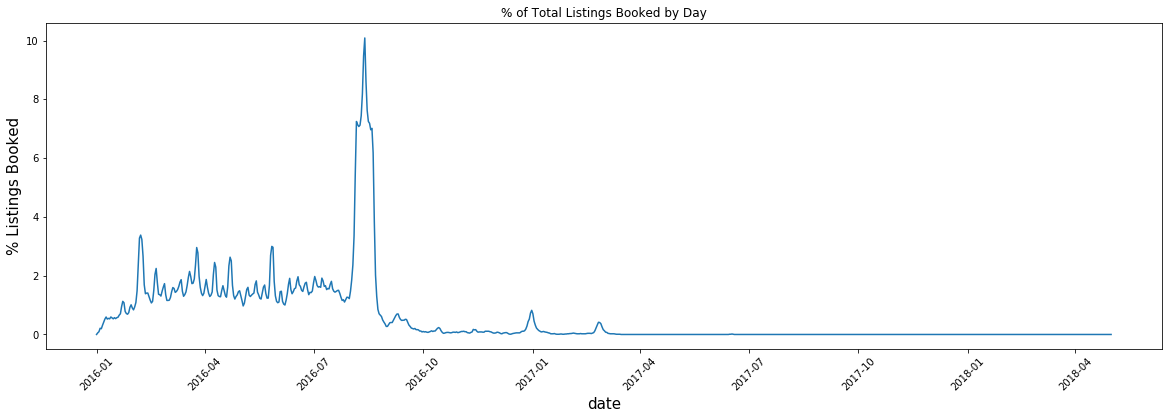

In [940]:
a = graph_booking(df,unique_date,dates_booked)

### new vs returning user inquiries per day

In [793]:
np.unique(df['guest_user_stage_first'])

array(['-unknown-', 'new', 'past_booker'], dtype=object)

In [945]:
def graph_inquiry_bookings(data, col, unique_date, metric = None, cohort = None):
    
    def plot(new_user_inq,metric,cohort=None):   
        plt.figure(figsize=(20,6))
        plt.xticks(rotation=45)
        plt.plot(new_user_inq)
        plt.xlabel('date',fontsize=15)
        plt.ylabel('# of %s' % metric,fontsize=15)
        if cohort is not None:
            plt.title('# %s per Day %s' % (metric,str(cohort)))
        else:
            plt.title('# %s per Day' % metric)
            print ('./data/%s.png' % metric)
            plt.savefig('./data/%s.png' % metric, bbox_inches='tight')
        plt.show()
    
    def process(new_user_inq,unique_date):
        new_user_inq.reset_index(drop=True,inplace=True)
        new_user_inq = new_user_inq.apply(lambda x: pd.Timestamp(x.date()))
        new_user_inq = pd.DataFrame(new_user_inq.value_counts()).reset_index()
        new_user_inq.columns = ['date','ts_interaction_first']
        new_user_inq = unique_date.merge(new_user_inq,how='left')
        new_user_inq.fillna(0,inplace=True)
        new_user_inq = new_user_inq.set_index('date')
        return new_user_inq
    
    if cohort is not None:
        for c in np.unique(data[cohort]):
            new_user_inq = data[data[cohort] == c][col]
            new_user_inq = process(new_user_inq,unique_date)
            plot(new_user_inq,metric,cohort = c)
    else:
        new_user_inq = data[col]
        new_user_inq = process(new_user_inq,unique_date)
        plot(new_user_inq,metric)
            
    

./data/Inquiries.png


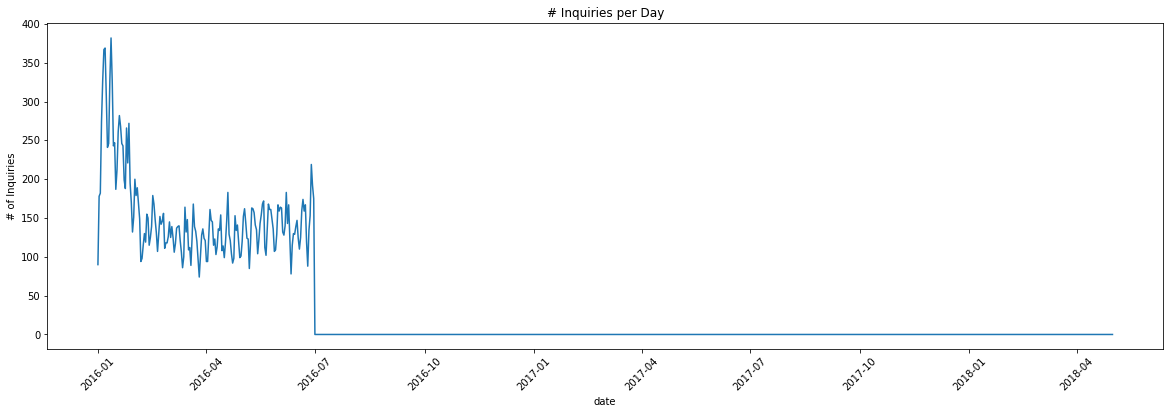

In [946]:
graph_inquiry_bookings(df,'ts_interaction_first',unique_date, metric = 'Inquiries')

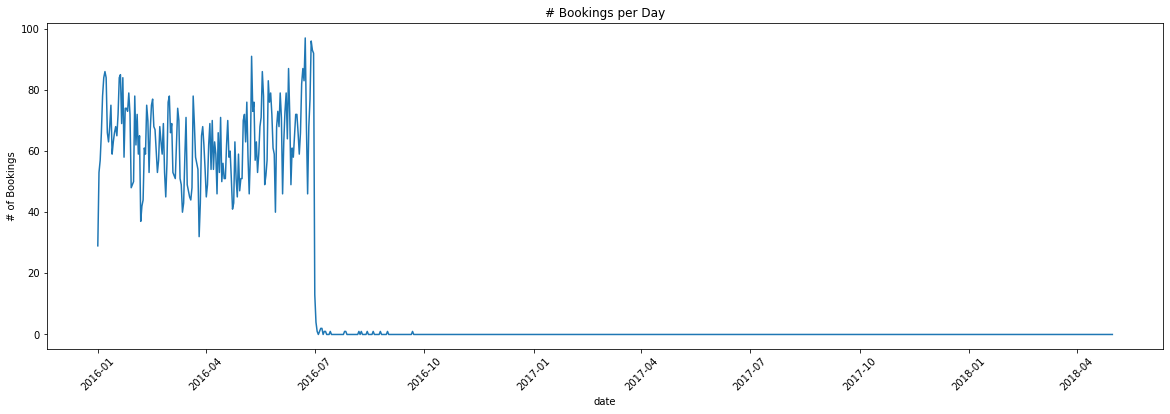

In [812]:
graph_inquiry(df,'ts_booking_at',unique_date,metric = 'Bookings')

### Model

In [875]:
feature_cols = [
            'm_guests',
            'm_interactions', 
            'm_first_message_length_in_characters',
            #'contact_channel_first', 
            'guest_user_stage_first',
            'booked', 
            'num_nights',
            'inq_to_checkin',
            'checkin_day_of_week',
            'host_country',
            'host_words_in_user_profile',
            'guest_country',
            'guest_words_in_user_profile',
            'room_type',
            'listing_neighborhood',
            'total_reviews',
            'host_replied']

In [876]:
prep_df = df[feature_cols]

In [879]:
cat_feature = [
    #'contact_channel_first',
    'guest_user_stage_first',
    'host_country',
    'checkin_day_of_week',
    'guest_country',
    'room_type',
    'listing_neighborhood',
    'host_replied']
df_train = prep_df[cat_feature]
tar_feature = 'booked'

In [880]:
def encoder(data, categorical_feature):
    enc = OneHotEncoder()
    array_sparse = enc.fit_transform(np.array(data[categorical_feature]).reshape(-1,1))
    array = array_sparse.toarray()
    column_names = [x.replace("x0_",'{}_'.format(categorical_feature)).replace(".0","") for x in enc.get_feature_names()]
    return array_sparse, array, column_names

In [881]:
for cat in cat_feature:
    print(cat)
    array_sparse, array, column_names = encoder(df_train, cat)
    for i,col in enumerate(column_names[:-1]):
        df_train[col] = array[:,i]

guest_user_stage_first


/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


host_country


/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


checkin_day_of_week
guest_country
room_type
listing_neighborhood


/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


host_replied


/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [882]:
prep_df.drop(cat_feature, axis=1, inplace=True)
df_train.drop(cat_feature, axis=1, inplace=True)

/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [883]:
model_df = pd.concat([prep_df,df_train],axis=1)

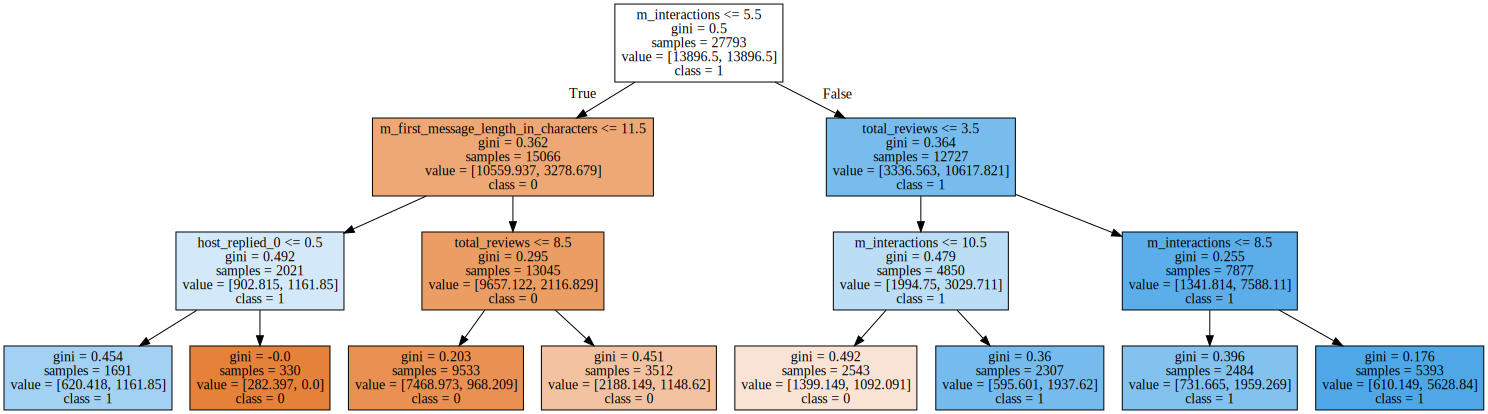

In [884]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_tree = DecisionTreeClassifier( max_depth=3, min_samples_leaf = 30, class_weight="balanced", min_impurity_decrease = 0.001)
dt_tree.fit(model_df.drop('booked',axis=1), model_df['booked'])

from IPython.display import SVG
from graphviz import Source
from sklearn import tree
from IPython.display import display
graph = Source(tree.export_graphviz(dt_tree, out_file=None
   , feature_names=model_df.drop('booked',axis=1).columns, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [885]:
#Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
model_df.drop('booked',axis=1), model_df['booked'], test_size=0.20, random_state=42)
import statsmodels.api as sm
mod = sm.Logit(endog=y_train, exog=X_train)
res = mod.fit(method='bfgs', maxiter=100)
print (res.summary())

/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.423754
         Iterations: 100
         Function evaluations: 110
         Gradient evaluations: 105
                           Logit Regression Results                           
Dep. Variable:                 booked   No. Observations:                22234
Model:                          Logit   Df Residuals:                    22010
Method:                           MLE   Df Model:                          223
Date:                Sat, 15 Jun 2019   Pseudo R-squ.:                  0.3751
Time:                        21:45:34   Log-Likelihood:                -9421.7
converged:                      False   LL-Null:                       -15078.
                                        LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
m_g

/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  
/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  
/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  Parameters


In [886]:
from sklearn.metrics import roc_auc_score
predicted = res.predict(X_test)
auc = roc_auc_score(y_true=y_test, y_score=predicted)
print ('AUC for 20%% holdout: %s' %auc)

AUC for 20% holdout: 0.8806028370579799


In [958]:
model_df.drop('booked', axis=1)

m_guests  m_interactions  m_first_message_length_in_characters  \
0             4              30                                    31   
1             5               2                                   312   
2             1               3                                   164   
3             2               3                                   203   
4             3              25                                     0   
5             1               7                                   348   
6             6               7                                    29   
7             1               8                                   782   
8             1               6                                     0   
9             4               6                                   128   
10            4               2                                   128   
11            4               6                                   280   
12            2               2                                   176   
13            2               8                                   290   
14            3               5                                   165   
15            1             143                                   395   
16            3               2                                   196   
17            4               5                                    81   
18            8               4                                   149   
19            2              21                                   550   
20            1               2                                   409   
21            1               7                                    41   
22            2               5                                    32   
23            1              15                                   342   
24            1               8                                   317   
25            5              10                                   255   
26            1               5                                   217   
27            2               5                                   700   
28            1               3                                    22   
29            2               9                                   269   
...         ...             ...                                   ...   
27763         4               3                                   146   
27764         1               7                                   370   
27765         2               6                                   279   
27766         2               6                                    72   
27767         5               4                                    89   
27768         1               2                                   196   
27769         1              16                                   238   
27770         3               3                                   182   
27771         2               7                                     0   
27772         4               3                                   274   
27773         4               3                                    11   
27774         1              20                                   121   
27775         2               5                                     0   
27776         1              13                                    78   
27777         4              64                                   167   
27778         1               4                                   229   
27779         2              22                                   199   
27780         4              22                                   324   
27781         2               9                                   518   
27782         5               1                                     0   
27783         3               2                                    67   
27784         2               3                                   137   
27785         2              15                                  

In [959]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

print (clf.predict(X_test))

print (clf.predict_proba(X_test)[0:10])

auc = roc_auc_score(y_true=y_test, y_score=clf.predict(X_test))
print (auc)
feat_import = {}
for i,x in zip(model_df.drop('booked', axis=1).columns,clf.feature_importances_):
    feat_import[i] = x

    import operator

sorted_x = sorted(feat_import.items(), key=operator.itemgetter(1),reverse=True)

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0 0 0 ... 0 1 0]
[[0.5 0.5]
 [0.9 0.1]
 [0.9 0.1]
 [0.2 0.8]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]
 [0.4 0.6]
 [0.9 0.1]
 [0.6 0.4]]
0.7989948873171917


### Univariate Plots

In [978]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")


In [979]:
def dist_uni_plot(data,col,target,cohort=None,xlim = None):
    
    def run():
        if cohort is not None:
            cohorts = set(data[cohort])
            for c in cohorts:
                data_cohort = data[data[cohort] == c]
                plot(data_cohort,col,target,cohort = c)
        else:
            plot(data,col,target,cohort=None)
    
    def plot(data,col,target,cohort=None):
        data = data[data[col].notnull()]
        grouped = data[[col,target]].groupby(col).mean().reset_index()
        hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
        sns.distplot(data[data[target]==0][col],label='Booked 0',
                    ax=ax[0], hist_kws = hist_kws)
        sns.distplot(data[data[target]==1][col],label='Booked 1',
                    ax=ax[0], hist_kws = hist_kws)
        
        if cohort is not None:
            ax[0].set_title('Count Plot of {}'.format(col) + '  {}'.format(cohort), fontsize=16)
        else:
            ax[0].set_title('Count Plot of {}'.format(col), fontsize=16)
        ax[0].legend()
        ax[1].plot(grouped[col],grouped[target],'.-')
        if cohort is not None:
            ax[1].set_title('Mean Conversion Rate vs. {}'.format(col) + '  {}'.format(cohort), fontsize=16)
        else:
            ax[1].set_title('Mean Conversion Rate vs. {}'.format(col), fontsize=16)
        ax[1].set_xlabel('{}'.format(col))
        plt.xlim([0,xlim])
        ax[1].set_ylabel('Mean Convertion Rate')
        ax[1].grid(True)
        plt.tight_layout()
        pdf.savefig( fig )
        plt.show()
        
    run()
    

In [980]:
cutoff = {}
cutoff['m_interactions'] = 50
cutoff['m_first_message_length_in_characters'] = 500
cutoff['total_reviews'] = 50
cutoff['inq_to_checkin'] = 200
cutoff['num_nights'] = 50
cutoff['host_words_in_user_profile'] = 175

m_interactions


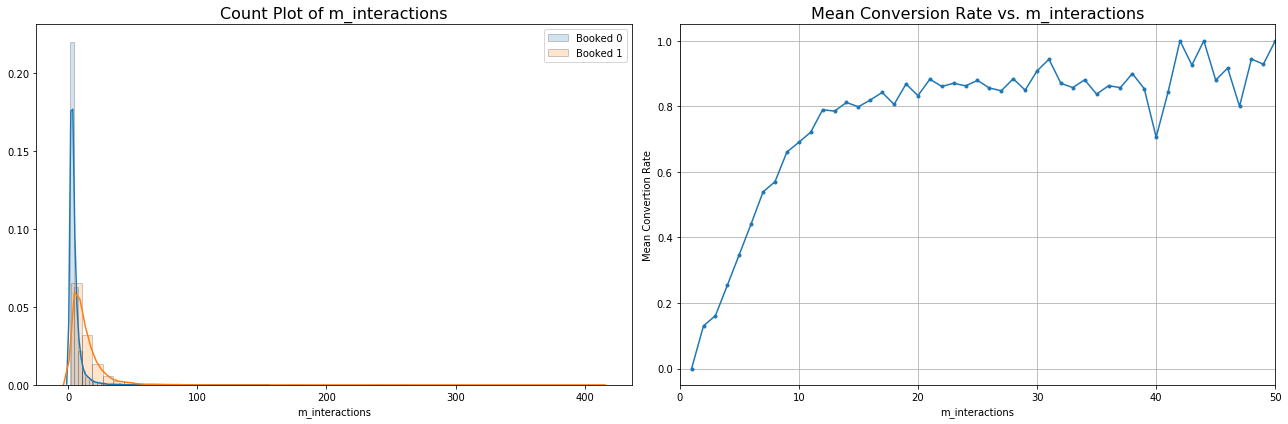

m_first_message_length_in_characters


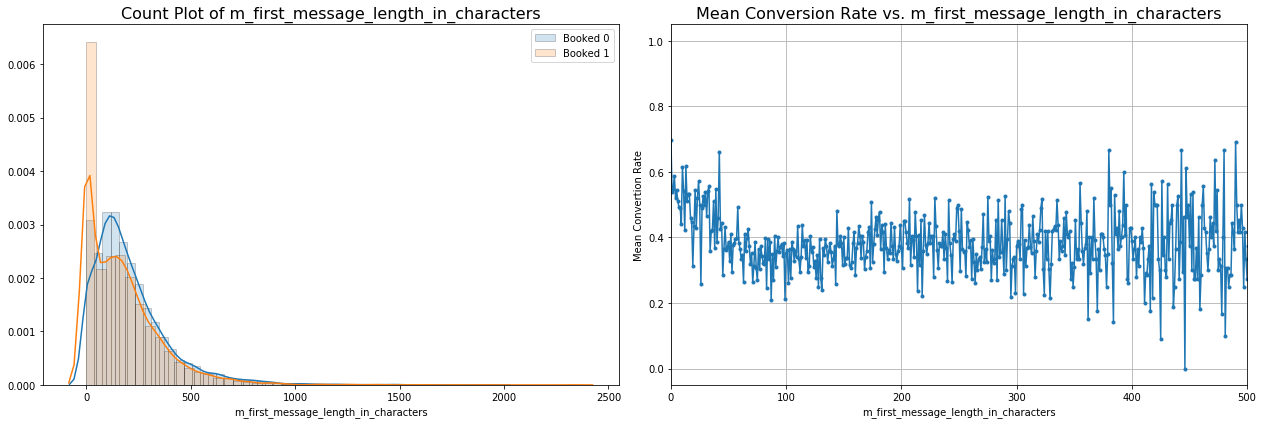

total_reviews


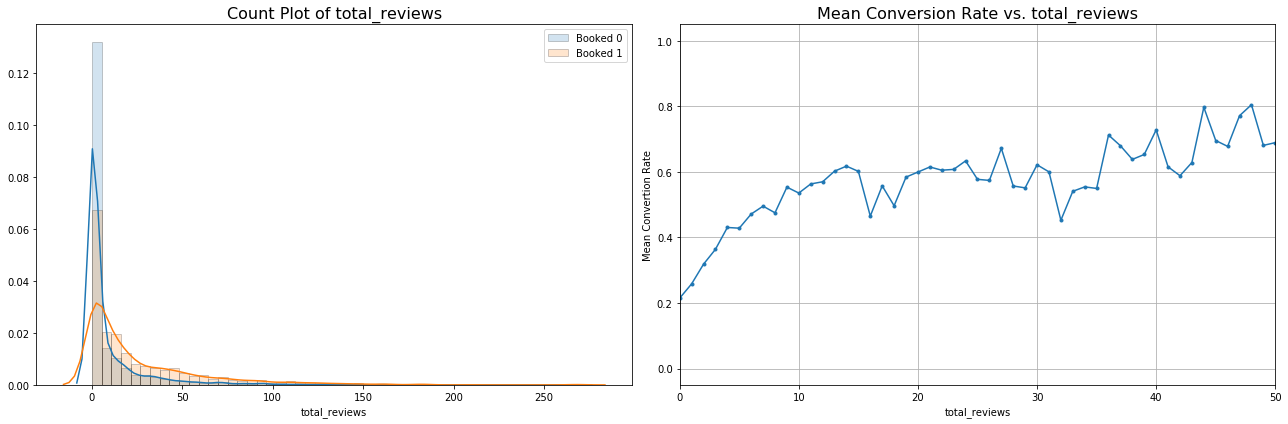

inq_to_checkin


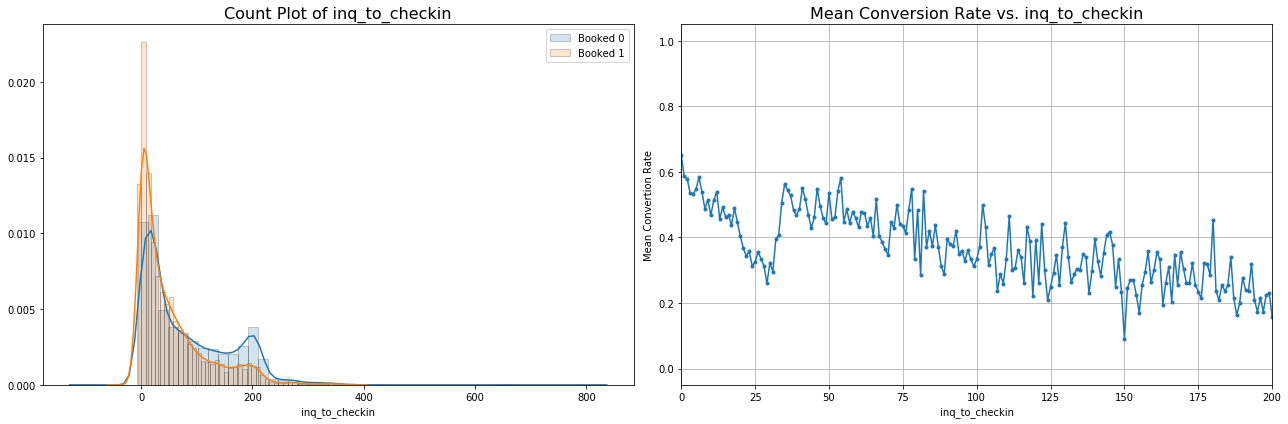

num_nights


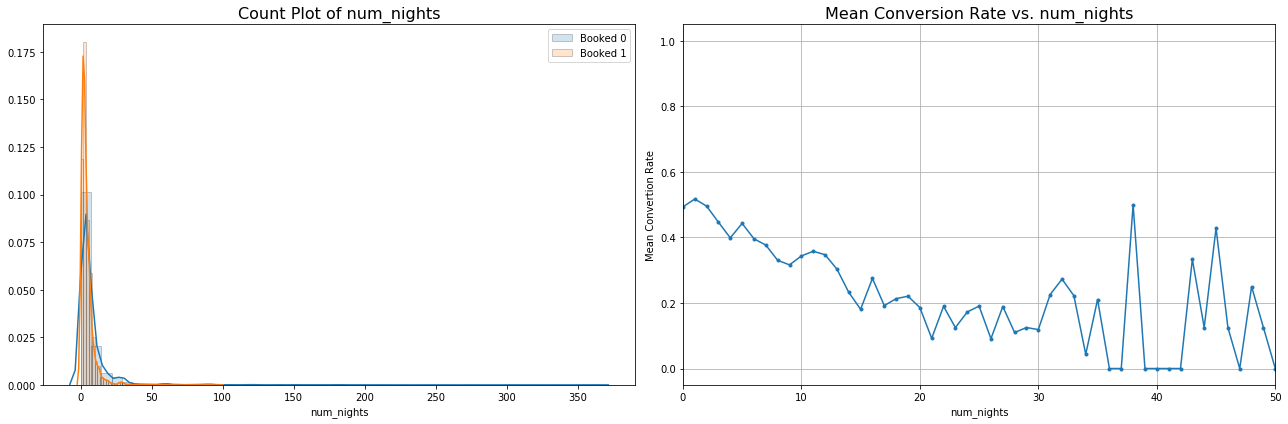

host_words_in_user_profile


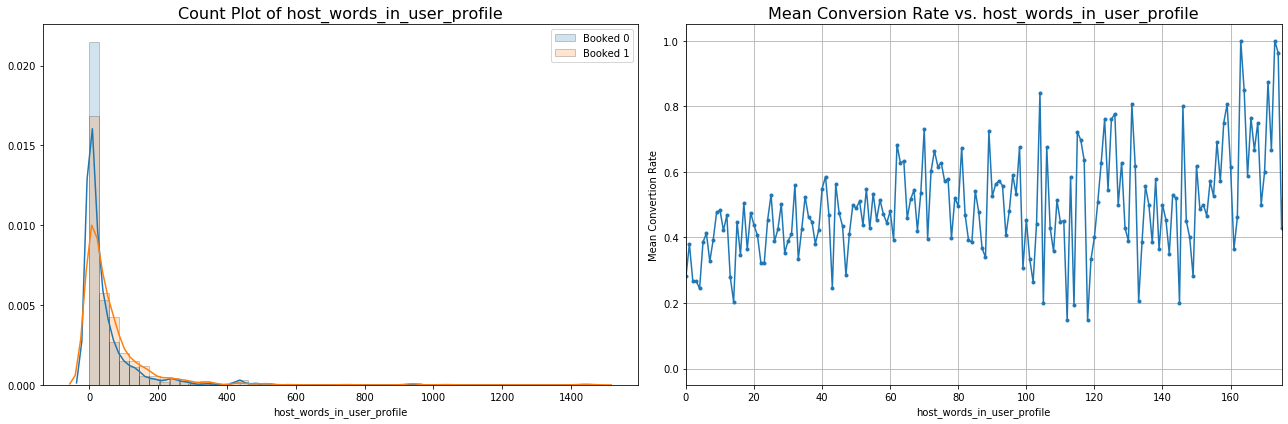

In [981]:
for col,_ in sorted_x[:6]:
    print (col)
    dist_uni_plot(model_df,col,'booked',xlim = cutoff[col])
pdf.close()